# ML-II Final Project
# Time Series Forecasting
# Regression and Classification

## Talal Sagheer Ahmed Khan
## ERP ID: 01624

In this project we will conduct time series analysis for price prediction for financial assets, mainly stocks and cryptocurrency, using multiple regression and classification techniques

## Regression Techniques - Stock Price Prediction

For this part we will use the weekly return of the Microsoft (MSFT) stock as the predicted variable. For this we will first see that what variables affect Microsoft's stock price and then try to incorporate as much information from that into our model.

For the first part of our project we will be using the historical data of Microsoft's stock price, the independent variables we will be using are the following potentially correlated assets:

Stocks: IBM (IBM) and Alphabet (GOOGL)
Currency: USD/JPY (DEXJPUS) and GBP/USD (DEXUSUK)
Indices: S&P 500 (SP500), Dow Jones (DJIA) and VIX (VIXCLS)

## Loading Python Packages

In [4]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

## Loading Data

Next we load our datasets. We will be using live data feeds from Yahoo Finance for stock prices and for our currency pairs and indices we will be using data feed from Federal Reserve Economic Data. 

In [5]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

For a series to predict, we will choose to predict using weekly returns. We approximate this by using 5 business day period returns.



In [6]:
return_period = 5

We now define our Y series and our X series

Y: MSFT Future Returns

X:

a. GOOGL 5 Business Day Returns
b. IBM 5 Business DayReturns    
c. USD/JPY 5 Business DayReturns    
d. GBP/USD 5 Business DayReturns    
e. S&P 500 5 Business DayReturns    
f. Dow Jones 5 Business DayReturns    
g. MSFT 5 Business Day Returns    
h. MSFT 15 Business Day Returns    
i. MSFT 30 Business Day Returns    
j. MSFT 60 Business Day Returns

We remove the MSFT past returns when we use the Time series models

In [7]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

## Exploratory Data Analysis

In [8]:
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,225.000,225.000,225.000,2.250e+02,2.250e+02,225.000,225.000,225.000,225.000,2.250e+02,225.000,225.000
mean,0.007,0.005,-0.001,2.863e-04,-1.531e-04,0.002,0.002,0.002,0.007,2.256e-02,0.044,0.085
std,0.034,0.035,0.037,9.068e-03,1.218e-02,0.025,0.027,0.175,0.033,4.998e-02,0.061,0.072
min,-0.179,-0.168,-0.231,-3.313e-02,-7.267e-02,-0.198,-0.209,-0.495,-0.179,-2.823e-01,-0.229,-0.124
25%,-0.009,-0.013,-0.015,-5.029e-03,-7.025e-03,-0.005,-0.006,-0.078,-0.008,-1.076e-04,0.015,0.051
50%,0.010,0.006,0.002,8.831e-04,-2.875e-04,0.005,0.004,-0.007,0.010,2.413e-02,0.047,0.086
75%,0.026,0.025,0.016,6.035e-03,6.589e-03,0.014,0.013,0.074,0.026,4.873e-02,0.082,0.130
max,0.090,0.124,0.118,4.089e-02,4.258e-02,0.099,0.116,0.923,0.090,1.565e-01,0.264,0.377


In [10]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-03-30,3.044e-04,0.012,-0.006,0.002,-2.958e-03,0.009,0.003,-0.128,1.287e-02,0.015,0.018,0.055
2017-04-06,-1.194e-02,-0.005,-0.008,-0.003,-2.402e-04,-0.004,-0.003,0.071,3.044e-04,0.017,0.017,0.055
2017-04-13,2.208e-02,-0.006,-0.017,-0.016,2.879e-03,-0.012,-0.010,0.253,-1.194e-02,0.001,0.015,0.044
2017-04-24,2.746e-02,0.027,-0.062,0.012,1.545e-02,0.011,0.006,-0.302,3.083e-02,0.025,0.039,0.056
2017-05-01,-6.795e-03,0.060,-0.012,0.018,1.043e-02,0.006,0.007,-0.070,2.746e-02,0.055,0.068,0.100


## Data Visualization

We now see the data distribution of each of our columns. We can see that each of the dataset follows a Gaussian distribution, however, the skewness and distribution varies.

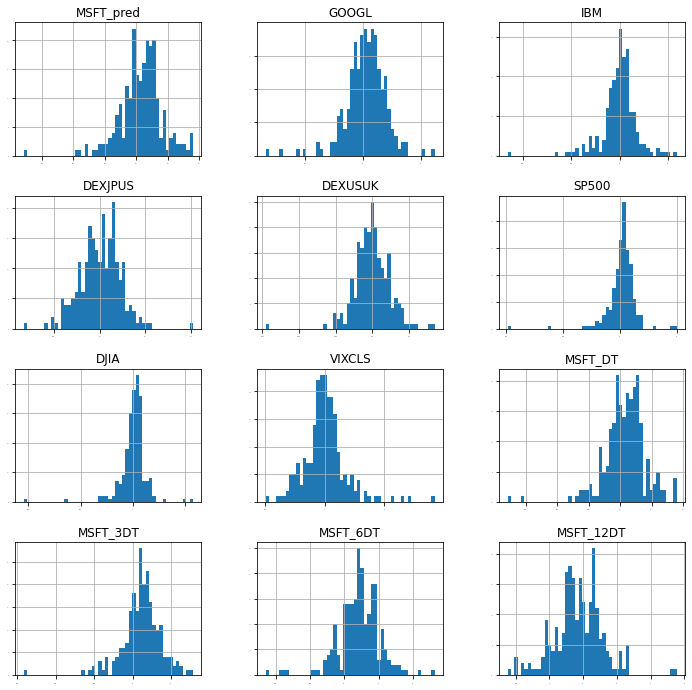

In [11]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

We will now visualize the density distribution of all our columns over the same x-axis scale

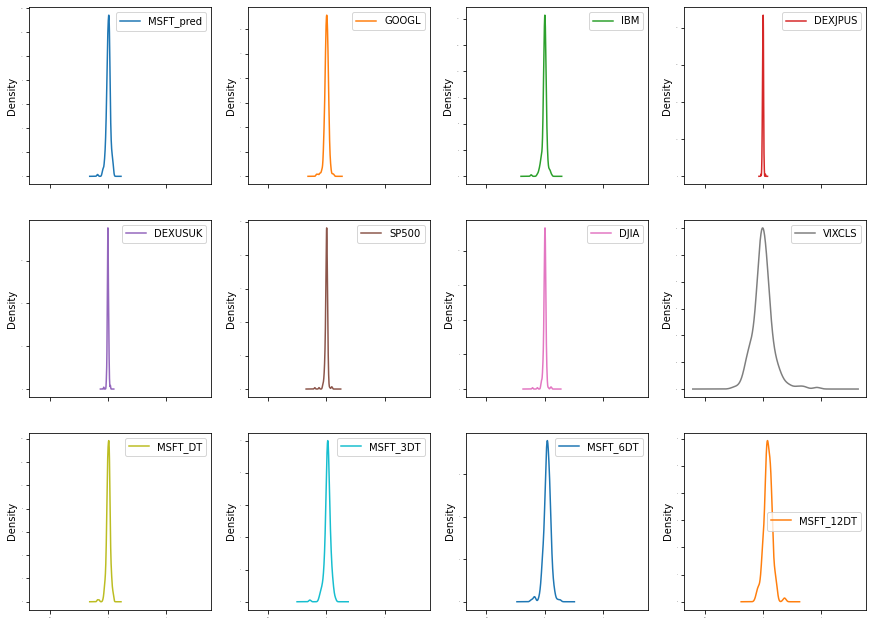

In [12]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

Here we can see that the VIX (which is a voaltility index) has a much larger variance compared to the other distributions.

To understand the interdependence of the data we look at correlation matrix and the scatter plot

<AxesSubplot:title={'center':'Correlation Matrix'}>

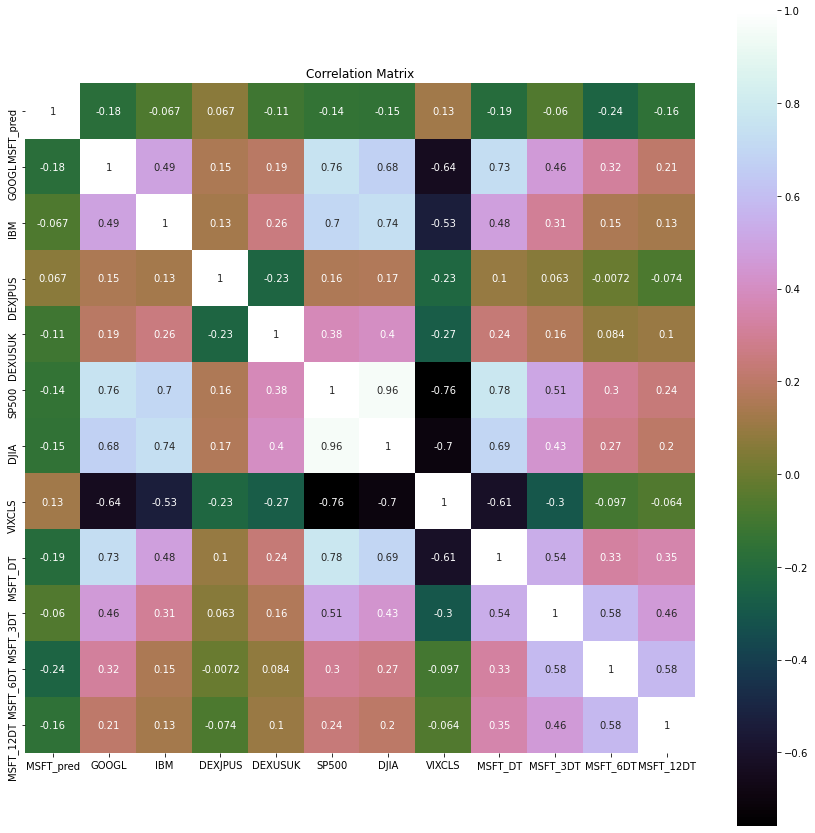

In [14]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Looking at the correlation plot above, we see some correlation of the predicted variable with the lagged 5 days, 15days, 30 days and 60 days return of MSFT.



<Figure size 1080x1080 with 0 Axes>

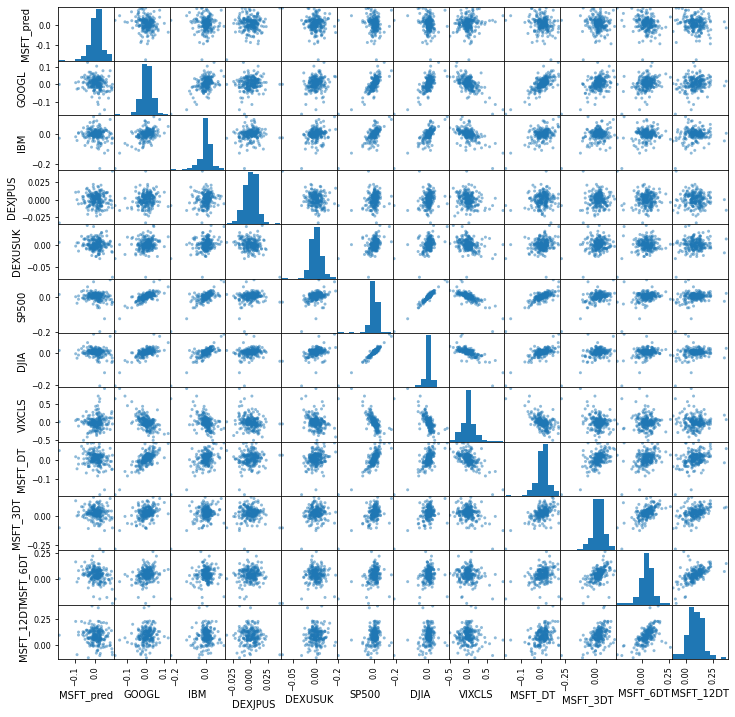

In [15]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

Looking at the scatter plot above, we see some linear relationship of the predicted variable the lagged 15 days, 30 days and 60 days return of MSFT.




## Time Series Analysis

Next, we look at the seasonal decomposition of our time series



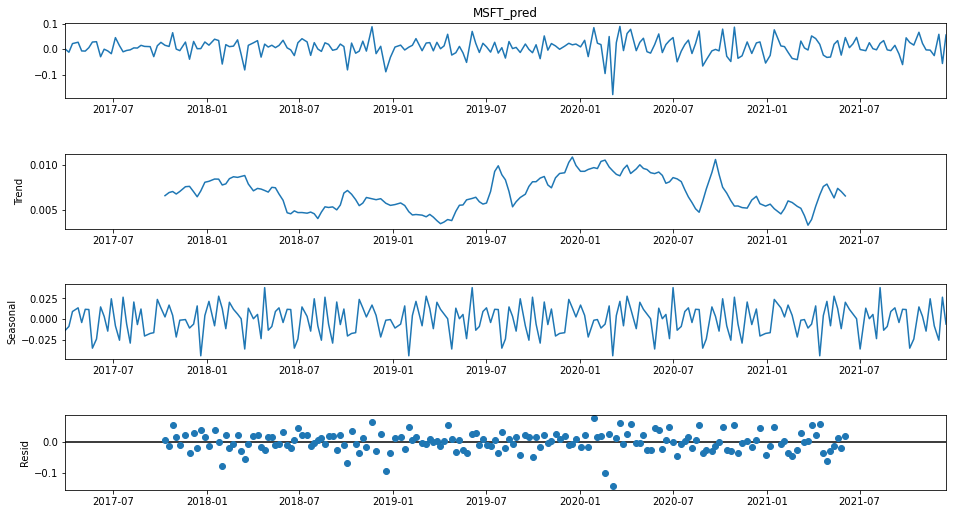

In [16]:
res = sm.tsa.seasonal_decompose(Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

We can see that for MSFT there has been a general trend upwards. This will be more evident in our constant/bias terms in the models




## Data Preparation

### Feature Selection 

To get a sense of feature importance we will be using sklearn's SelectKBest function.



In [18]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_6DT,13.573
MSFT_DT,8.572
GOOGL,7.192
MSFT_12DT,5.533
DJIA,5.157
SP500,4.566
VIXCLS,3.688
DEXUSUK,2.856
IBM,1.010


We see that Microsoft_6DT (Microsoft's 30 day return) seems to be the most important feature and Japanese Yen to Dollar being the least important.




## Evaluate Algorithms & Models

### Train-Test Split & Evaluation Metrics

We will now split our data in training and testing chunks. Since we going to use Time series models we will have to split the data in continous series.



In [20]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

## Test Options & Evaluation Metrics

In [21]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

## Comparing Models & Algorithms

### Regression and Tree Regression algorithms


In [22]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))


### Neural Network algorithms


In [23]:
models.append(('MLP', MLPRegressor()))


### Ensemble Models


In [24]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them. First we run the K-fold analysis. Next we run the model on the entire training and testing dataset.



In [26]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001277 (0.000946) 0.001055 0.000904
LASSO: 0.001208 (0.000990) 0.001202 0.001020
EN: 0.001208 (0.000990) 0.001202 0.001020
KNN: 0.001359 (0.001105) 0.000928 0.001016
CART: 0.002515 (0.001763) 0.000000 0.002057
SVR: 0.002374 (0.000659) 0.002313 0.002237
MLP: 0.002771 (0.001913) 0.001895 0.001512
ABR: 0.001437 (0.001058) 0.000608 0.000888
GBR: 0.001641 (0.001265) 0.000089 0.001202
RFR: 0.001348 (0.001012) 0.000195 0.000927
ETR: 0.001395 (0.000989) 0.000000 0.000963


### K Fold results


We begin by looking at the K Fold results



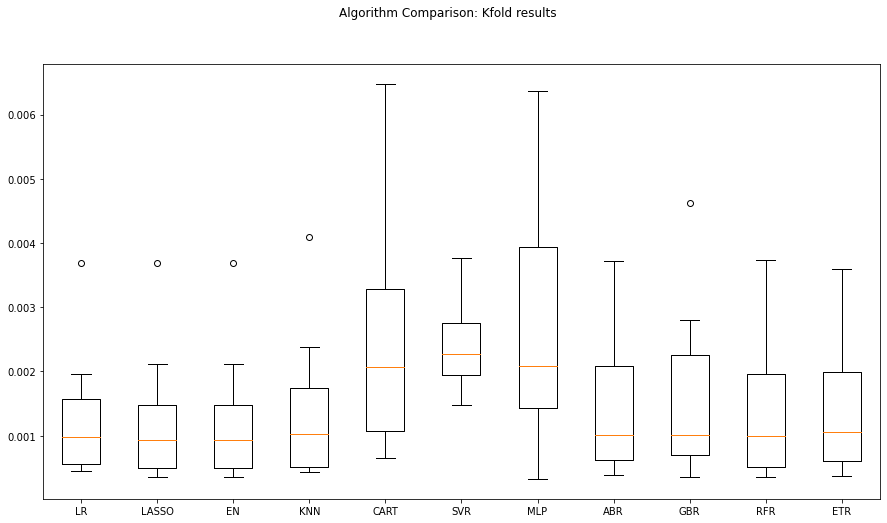

In [27]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

We see the linear regression and the regularized regression including the Lasso regression (LASSO) and elastic net (EN) seem to do a good job.



### Training and Test error


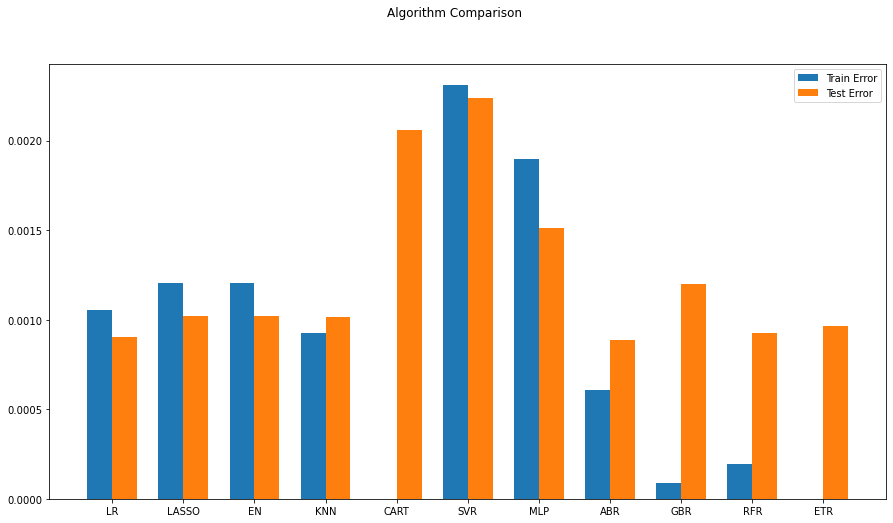

In [28]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Looking at the training and test error, we still see a better performance of the linear models. Some of the algorithms, such as the decision tree regressor (CART) overfit on the training data and produced very high error on the test set and these models should be avoided. Ensemble models, such as gradient boosting regression (GBR) and random forest regression (RFR) have low bias but high variance. We also see that the artificial neural network (shown as MLP in the chart) algorithm shows higher errors both in training set and test set, which is perhaps due to the linear relationship of the variables not captured accurately by ANN or improper hyperparameters or insufficient training of the model.

## Time Series based models - ARIMA and LSTM


We will now prepare the dataset for ARIMA models, by having only the correlated varriables as exogenous variables.



### ARIMA Model


In [29]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [30]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [31]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.001045526214874182

### LSTM Model


In [32]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [33]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

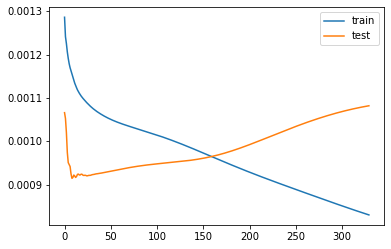

In [34]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [35]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

We will now append our current results to our previous results

In [36]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

## Overall Comparison of all the algorithms ( including Time Series Algorithms)


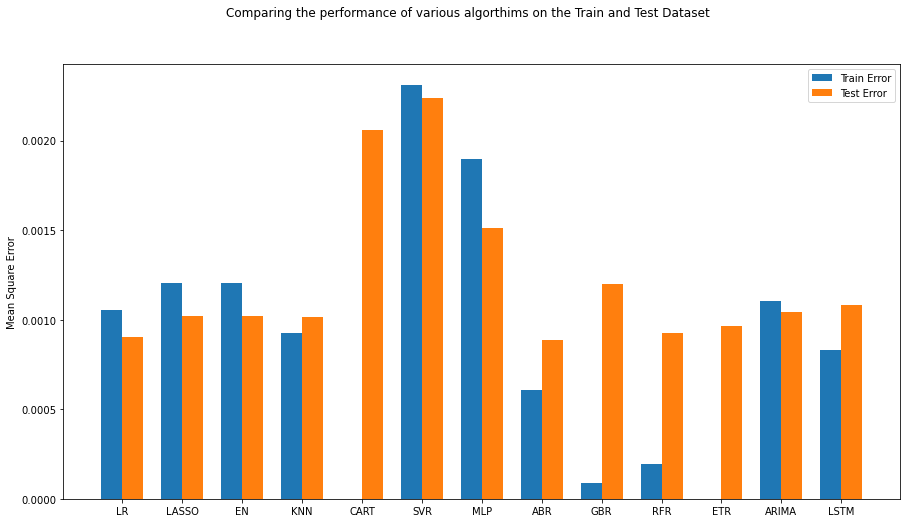

In [37]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

Looking at the chart above, we find time series based ARIMA model comparable to the linear supervised-regression models such as Linear Regression (LR), Lasso Regression (LASSO) and Elastic Net (EN). This can primarily be due to the strong linear relationship as discussed before. The LSTM model performs decently, however, ARIMA model outperforms the LSTM model in the test set. Hence, we select the ARIMA model for the model tuning.

## Model Tuning and Grid Search


As shown in the chart above the ARIMA model is one of the best mode, so we perform the model tuning of the ARIMA model. The default order of ARIMA model is [1,0,0]. We will now perform a grid search with different combinations of p,d and q in the ARIMA model's order.

In [38]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

ARIMA(0, 0, 0) MSE=0.0011206
ARIMA(0, 0, 1) MSE=0.0010943
ARIMA(1, 0, 0) MSE=0.0011036
ARIMA(1, 0, 1) MSE=0.0010525
ARIMA(2, 0, 0) MSE=0.0010926
ARIMA(2, 0, 1) MSE=0.0010926
Best ARIMA(1, 0, 1) MSE=0.0010525


## Finalizing the Model



### Test Dataset Results


In [39]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

In [40]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.001045526214874182


After tuning the model and picking the best ARIMA model or the order 1,0 and 1 we select this model and can it can be used for the modeling purpose.




### Saving Model for Future Use


In [41]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))

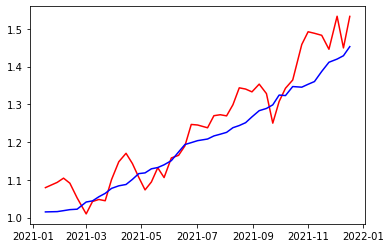

In [42]:
#Use the following code to produce the comparison of actual vs. predicted
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
pyplot.rcParams["figure.figsize"] = (8,5)
pyplot.show()

### Summary

We can conclude that simple models - linear regression, regularized regression (i.e. Lasso and elastic net) - along with the time series model such as ARIMA are promis‐ ing modelling approaches for asset price prediction problem. These models can enable financial practitioners to model time dependencies with a very flexible approach. The overall approach presented in this case study may help us encounter overfitting and underfitting which are some of the key challenges in the prediction problem in finance. We should also note that we can use better set of indicators, such as P/E ratio, trading volume, technical indicators or news data, which might lead to better results. We will demonstrate this in some of the case studies in the book. Overall, we created a supervised-regression and time series modelling framework which allows us to perform asset class prediction using historical data to generate results and analyze risk and profitability before risking any actual capital.

## Classification Techniques - Bitcoin Price Prediction & Trading Strategy

For this part we will be making an automated trader for Bitcoin which will predict a buy or sell signal for a trading strategy that is defined in the classification framework, where the predicted variable has a value of 1 for buy and 0 for sell.

The buy or sell signals are decided on the basis on the comparison of short term vs. long term price and using financial technical indicators such as moving averages and RSIs.

The dataset being used for this part of the project is availale on Kaggle at: https://www.kaggle.com/mczielinski/bitcoin-historical-data

## Loading Python Packages

In [6]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [14]:
# load dataset
dataset = pd.read_csv('C:\\Users\\LENOVO\\Downloads\\BitstampData.csv')

## Exploratory Data Analysis

### Decriptive Statistics

In [15]:
dataset.shape

(2841377, 8)

In [16]:
set_option('display.width', 100)
dataset.tail(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
2841372,1496188560,2190.49,2190.49,2181.37,2181.37,1.700,3723.785,2190.247
2841373,1496188620,2190.50,2197.52,2186.17,2195.63,6.561,14402.812,2195.206
2841374,1496188680,2195.62,2197.52,2191.52,2191.83,15.663,34361.024,2193.792
2841375,1496188740,2195.82,2216.00,2195.82,2203.51,27.090,59913.493,2211.621
2841376,1496188800,2201.70,2209.81,2196.98,2208.33,9.962,21972.309,2205.649


In [17]:
# describe data
set_option('precision', 3)
dataset.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,2.841e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06
mean,1.411e+09,4.959e+02,4.962e+02,4.955e+02,4.959e+02,1.188e+01,5.316e+03,4.959e+02
std,4.938e+07,3.642e+02,3.645e+02,3.639e+02,3.643e+02,4.094e+01,1.998e+04,3.642e+02
min,1.325e+09,3.800e+00,3.800e+00,1.500e+00,1.500e+00,0.000e+00,0.000e+00,3.800e+00
25%,1.368e+09,2.399e+02,2.400e+02,2.398e+02,2.399e+02,3.828e-01,1.240e+02,2.399e+02
50%,1.411e+09,4.200e+02,4.200e+02,4.199e+02,4.200e+02,1.823e+00,6.146e+02,4.200e+02
75%,1.454e+09,6.410e+02,6.417e+02,6.402e+02,6.410e+02,8.028e+00,3.108e+03,6.410e+02
max,1.496e+09,2.755e+03,2.760e+03,2.752e+03,2.755e+03,5.854e+03,1.866e+06,2.754e+03


## Data Preparation

### Data Cleaning

In [18]:
print('Null Values =',dataset.isnull().values.any())

Null Values = True


In [19]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()


In [20]:
dataset=dataset.drop(columns=['Timestamp'])

## Preparing the data for Classification
We attach a label to each movement:

1 if the signal is that short term price will go up as compared to the long term.

0 if the signal is that short term price will go down as compared to the long term.

In [21]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [23]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
2841372,2190.49,2190.49,2181.37,2181.37,1.700,3723.785,2190.247,2179.259,2189.616,0.0
2841373,2190.50,2197.52,2186.17,2195.63,6.561,14402.812,2195.206,2181.622,2189.877,0.0
2841374,2195.62,2197.52,2191.52,2191.83,15.663,34361.024,2193.792,2183.605,2189.943,0.0
2841375,2195.82,2216.00,2195.82,2203.51,27.090,59913.493,2211.621,2187.018,2190.204,0.0
2841376,2201.70,2209.81,2196.98,2208.33,9.962,21972.309,2205.649,2190.712,2190.510,1.0


## Feature Engineering
We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

The current Data of the Bitcoin consists of date, open, high, low, close and Volume. Using this data we calculate the following technical indicators:

Moving Average : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart.

Stochastic Oscillator %K and %D : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.

Relative Strength Index(RSI) :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.

Rate Of Change(ROC): It is a momentum oscillator, which measures the percentage change between the current price and the n period past price.

Momentum (MOM) : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [24]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / \
    d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [25]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2841372,2190.49,2190.49,2181.37,2181.37,1.700,3723.785,2190.247,2179.259,2189.616,0.0,...,46.613,56.447,73.774,47.883,59.889,16.012,18.930,2179.259,2182.291,2220.727
2841373,2190.50,2197.52,2186.17,2195.63,6.561,14402.812,2195.206,2181.622,2189.877,0.0,...,47.638,93.687,71.712,93.805,65.119,26.697,20.096,2181.622,2182.292,2220.296
2841374,2195.62,2197.52,2191.52,2191.83,15.663,34361.024,2193.792,2183.605,2189.943,0.0,...,47.395,80.995,77.043,81.350,74.346,23.850,22.186,2183.605,2182.120,2219.802
2841375,2195.82,2216.00,2195.82,2203.51,27.090,59913.493,2211.621,2187.018,2190.204,0.0,...,48.213,74.205,82.963,74.505,83.220,32.602,27.716,2187.018,2182.337,2219.396
2841376,2201.70,2209.81,2196.98,2208.33,9.962,21972.309,2205.649,2190.712,2190.510,1.0,...,48.545,82.810,79.337,84.344,80.066,36.440,30.964,2190.712,2182.715,2218.980


In [26]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2841372,2190.49,2190.49,2181.37,2181.37,1.700,3723.785,2190.247,2179.259,2189.616,0.0,...,46.613,56.447,73.774,47.883,59.889,16.012,18.930,2179.259,2182.291,2220.727
2841373,2190.50,2197.52,2186.17,2195.63,6.561,14402.812,2195.206,2181.622,2189.877,0.0,...,47.638,93.687,71.712,93.805,65.119,26.697,20.096,2181.622,2182.292,2220.296
2841374,2195.62,2197.52,2191.52,2191.83,15.663,34361.024,2193.792,2183.605,2189.943,0.0,...,47.395,80.995,77.043,81.350,74.346,23.850,22.186,2183.605,2182.120,2219.802
2841375,2195.82,2216.00,2195.82,2203.51,27.090,59913.493,2211.621,2187.018,2190.204,0.0,...,48.213,74.205,82.963,74.505,83.220,32.602,27.716,2187.018,2182.337,2219.396
2841376,2201.70,2209.81,2196.98,2208.33,9.962,21972.309,2205.649,2190.712,2190.510,1.0,...,48.545,82.810,79.337,84.344,80.066,36.440,30.964,2190.712,2182.715,2218.980


In [27]:
#excluding columns that are not needed for our prediction.

dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)','short_mavg','long_mavg'], axis=1)

In [28]:
dataset = dataset.dropna(axis=0)


In [29]:
dataset.tail()

,Close,Volume_(BTC),Weighted_Price,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2841372,2181.37,1.700,2190.247,0.0,2181.181,2182.376,2211.244,0.431,-0.649,8.42,...,46.613,56.447,73.774,47.883,59.889,16.012,18.930,2179.259,2182.291,2220.727
2841373,2195.63,6.561,2195.206,0.0,2183.808,2183.231,2211.088,1.088,-0.062,23.63,...,47.638,93.687,71.712,93.805,65.119,26.697,20.096,2181.622,2182.292,2220.296
2841374,2191.83,15.663,2193.792,0.0,2185.266,2183.786,2210.897,1.035,-0.235,19.83,...,47.395,80.995,77.043,81.350,74.346,23.850,22.186,2183.605,2182.120,2219.802
2841375,2203.51,27.090,2211.621,0.0,2188.583,2185.058,2210.823,1.479,0.297,34.13,...,48.213,74.205,82.963,74.505,83.220,32.602,27.716,2187.018,2182.337,2219.396
2841376,2208.33,9.962,2205.649,1.0,2192.174,2186.560,2210.798,1.626,0.516,36.94,...,48.545,82.810,79.337,84.344,80.066,36.440,30.964,2190.712,2182.715,2218.980


## Data Visualization

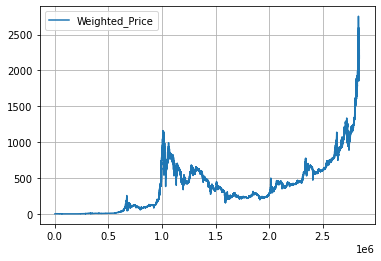

In [31]:
dataset[['Weighted_Price']].plot(grid=True)
plt.show()

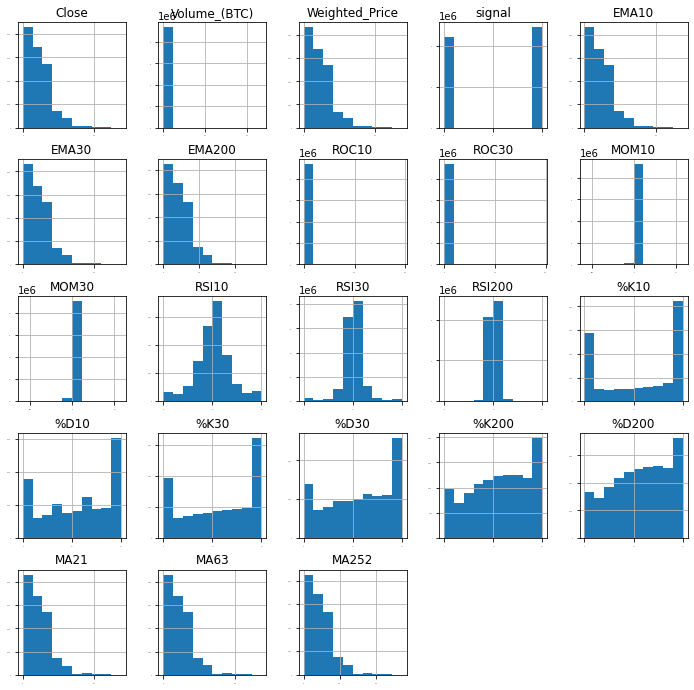

In [32]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

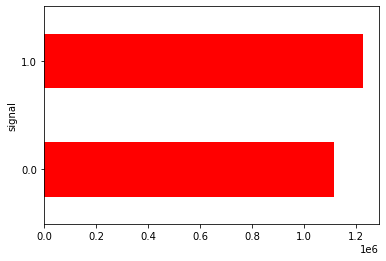

In [33]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

The predicted variable is upward 52.87% out of total data size, meaning that number of buy signals were more than the number of sell signals.



<AxesSubplot:title={'center':'Correlation Matrix'}>

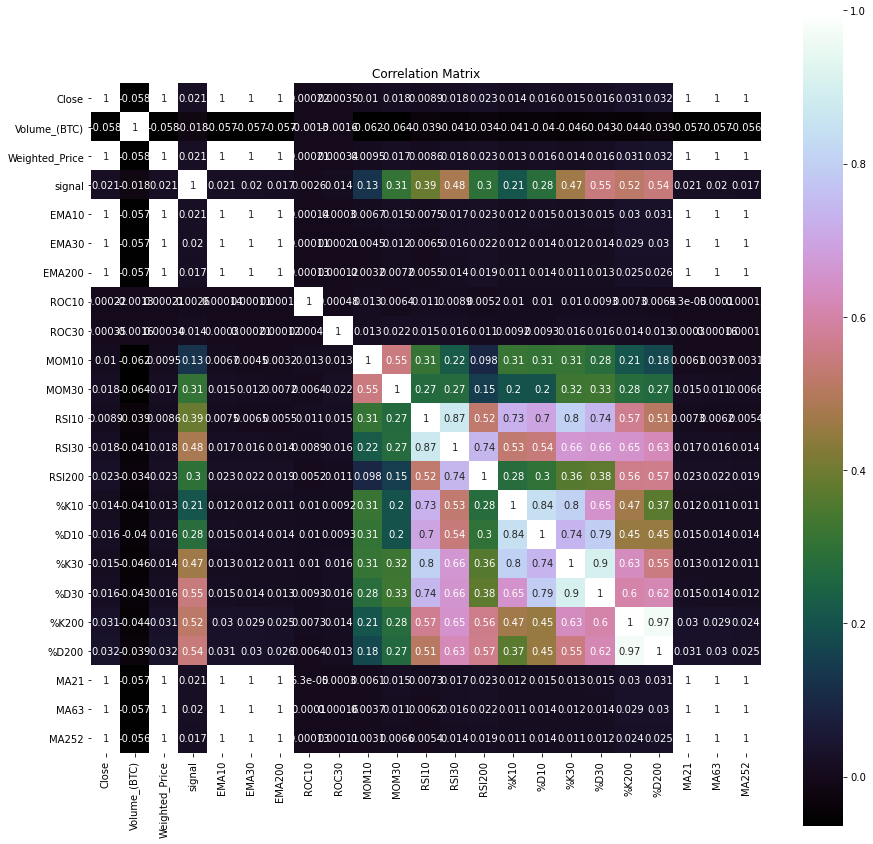

In [34]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

## Evaluate Algorithms and Models

### Train-Test Split

In [35]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

### Test Options and Evaluation Metrics


In [36]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

### Compare Models & Algorithms

In order to know which algorithm technique is the best for our strategy, we evaluate following non linear different methods:


#### Models

In [37]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

#### K-Folds Cross Validation

In [39]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.873663 (0.007692)
LDA: 0.889100 (0.005156)
KNN: 0.869550 (0.003698)
CART: 0.894988 (0.003141)
NB: 0.789662 (0.004442)
NN: 0.845513 (0.043246)
AB: 0.896400 (0.003303)
GBM: 0.908662 (0.003420)
RF: 0.929175 (0.003419)


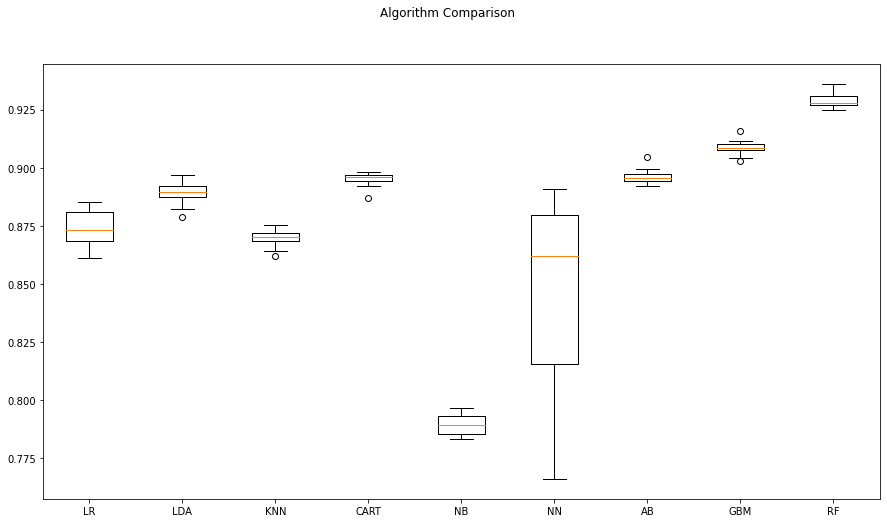

In [40]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

## Model Tuning & Grid Search

Random forest is selected for the grid search as it is one of the best models out of all.



In [42]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
'''   
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.902813 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.869137 (0.005218) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.869875 (0.002761) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.901850 (0.003641) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.902813 (0.002017) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.868887 (0.004955) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.870050 (0.003323) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.900962 (0.003070) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#2 0.902725 (0.003051) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


## Finalizing The Model

Finalizing the model with best parameters found during tuning step.




### Results on the Test Dataset


In [43]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [44]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9061
[[ 7833   985]
 [  893 10289]]
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89      8818
         1.0       0.91      0.92      0.92     11182

    accuracy                           0.91     20000
   macro avg       0.91      0.90      0.90     20000
weighted avg       0.91      0.91      0.91     20000



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

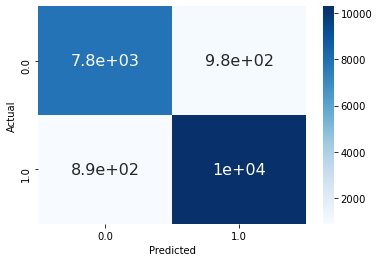

In [45]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

## Feature Importance

Text(0.5, 0, 'Variable Importance')

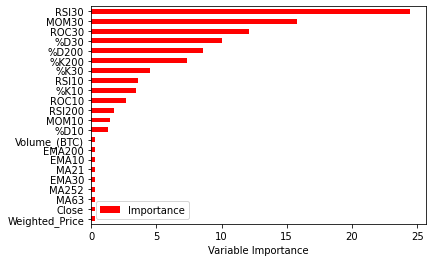

In [46]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

## Backtesting Results

<AxesSubplot:>

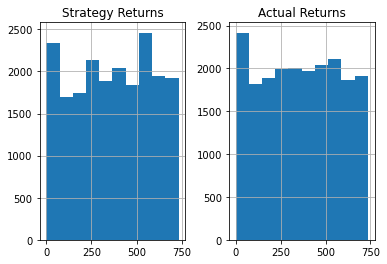

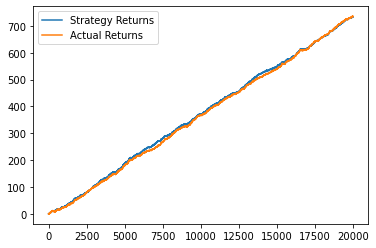

In [47]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

#### Conclusion:

Framing the problem is the first priority to address and this is done by engineering the features and transforming the labels according to our investment objective.

We demonstrated the efficiency of using feature engineering that leads to creation of intuitive features related to the trend and momentum of the price movement and increases the predictive power of the model.

In terms of the evaluation metrics for a classification-based trading strategy, accuracy or auc are appropriate, but in case the strategy is focusing to be more accurate while going long (that is to buy), the metric recall which focuses on less false positive can be preferred as compared to accuracy.

Finally, we can see that the backtesting framework which allows us to simulate a trading strategy using historical data to generate results and analyze risk and profitability before risking any actual capital.

## MCMC

### Dataset 1 - Train ticket prices

### Target & Goal of our MCMC Project

* We want to quantify our uncertainty
* We want to also use this to generate a model
* We want the answers as distributions not point estimates

In [2]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


In [3]:
data = pd.read_csv('renfe.csv')
data.drop('Unnamed: 0', axis = 1, inplace=True)
data = data.sample(frac=0.01, random_state=99)

In [4]:
data.head(3)

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
420104,2019-04-22 08:00:25,MADRID,SEVILLA,2019-04-28 08:30:00,2019-04-28 11:14:00,ALVIA,NaN,Turista,Flexible
431888,2019-04-22 10:03:24,MADRID,VALENCIA,2019-05-20 06:45:00,2019-05-20 08:38:00,AVE,21.95,Turista,Promo
791293,2019-04-25 19:19:46,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo


In [5]:
data.isnull().sum()/len(data)

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.119467
train_class    0.003993
fare           0.003993
dtype: float64

In [6]:
data['train_class'] = data['train_class'].fillna(data['train_class'].mode().iloc[0])
data['fare'] = data['fare'].fillna(data['fare'].mode().iloc[0])
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))

In [7]:
for i in ['start_date', 'end_date']:
    data[i] = pd.to_datetime(data[i])

In [8]:
data.shape

(25798, 9)

## Gaussian inferences

The KDE plot of the ticket price shows a Gaussian-like distribution, except for about several dozens of data points that are far away from the mean.

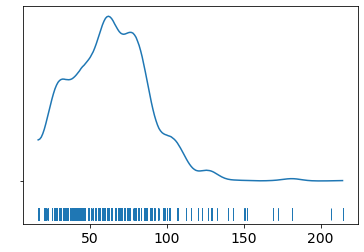

In [9]:
az.plot_kde(data['price'].values, rug=True)
plt.yticks([0], alpha=0);

Let's assume that a Gaussian distribution is a proper description of the ticket price. Since we do not know the mean or the standard deviation, we must set priors for both of them. Therefore, a reasonable model could be:

### Model

We will perform Gaussian inferences on the ticket price data. Here's some of the modelling choices that go into this.

Choices for price likelihood function:

The ticket price is modelled as a linear combination of the independent variables.
We assume that the ticket price is going to be normally distributed around the linear combination of independent variables with the same variance around the expected value.

That is how we proceed below:

#### We would instantiate the Models in PyMC3 like this.

* model specifications in PyMC3 are wrapped in a with-statement.

Choices of priors:

* μ, mean of a population. Normal distribution. Very wide. I do not know the possible values of μ, we can set priors reflecting our ignorance. From experience I know that train ticket price can not be lower than 0 or higher than 300, so I set the boundaries of the uniform distribution to be 0 and 300. You may have different experience and set the different boundaries. That is totally fine. And if you have more reliable prior information than I do, please use it!

* σ, standard deviation of a population. Can only be positive, therefore use HalfNormal distribution, again, very wide.

Choices for ticket price likelihood function:

* y is an observed variable representing the data that comes from a Normal distribution with the parameters μ and σ.

* draw 1000 posterior samples using NUTS sampling
 
Using PyMC3, we can write the model as follows:

In [10]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=0, upper=300)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data['price'].values)
    trace_g = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1028.50draws/s]


The "y" specifies the likelihood. This is the way in which we tell PyMC3 that we want to condition for the unknown on the knows (data). The observed values can be passed as a Python list, a tuple, a NumPy array, or a pandas DataFrame.

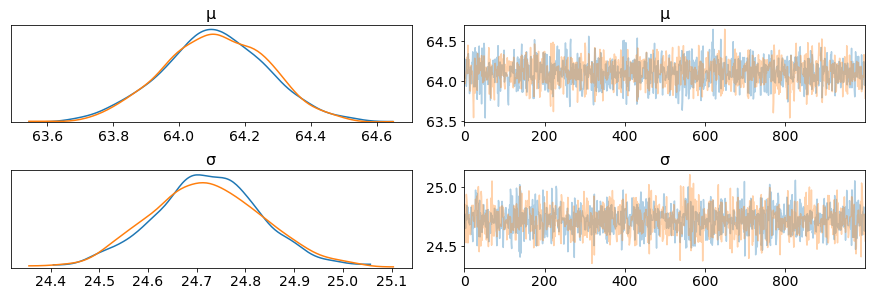

In [11]:
az.plot_trace(trace_g);

On the left, we have a KDE plot, – for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

On the right, we get the individual sampled values at each step during the sampling. From the trace plot, we can visually get the plausible values from the posterior.

The above plot has one row for each parameter. For this model, the posterior is bi-dimensional, and so the above figure is showing the marginal distributions of each parameter.

There are a couple of things to see here. 

* Our sampling chains for the individual parameters (left side) seem well converged and stationary (there are no large drifts or other odd patterns).

* The maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters.

We can plot a joint distributions of parameters. I don't see any correlation between these two parameters. This means we probably do not have collinearity in the model. This is good.

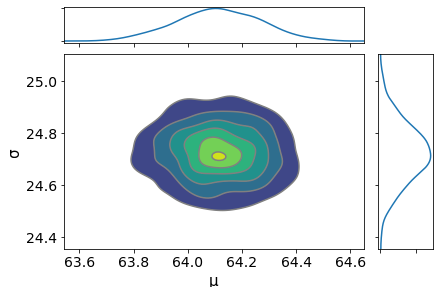

In [12]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

We can also have a detailed summary of the posterior distribution for each parameter:

In [13]:
az.summary(trace_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,64.109,0.158,63.807,64.398,0.003,0.002,2058.0,2058.0,2063.0,1576.0,1.0
σ,24.721,0.113,24.505,24.924,0.002,0.002,2058.0,2056.0,2054.0,1367.0,1.0


We can also see the above summay visually by generating a plot with the mean and HPD of a distribution.

We get the mean, standard deviation (sd), and 94% HPD interval (hpd 3% and hpd 97%). we can use these numbers to interpret and report the results of a Bayesian inference.

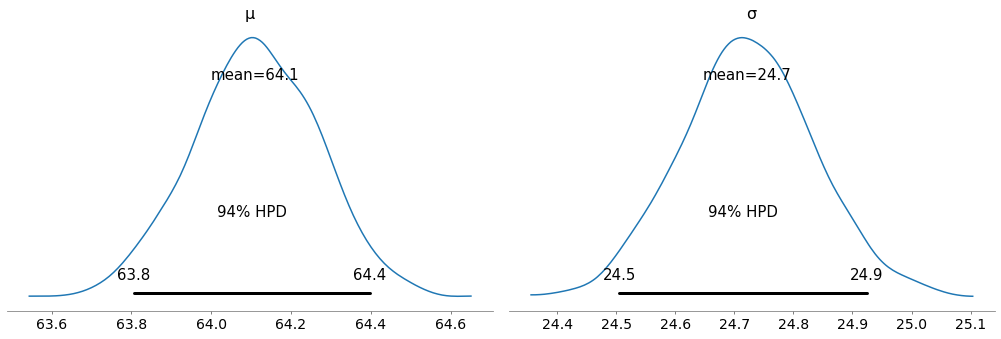

In [14]:
az.plot_posterior(trace_g);

Unlike Frequentist statistics, in Bayesian statistics, we get the entire distribution of the values.

Every time ArviZ computes and reports a HPD, it will use, by default, a value of 94%. please note that HPD intervals are not the same as confidence intervals. There is 94% probability the belief is between 63.8 and 64.4 for the mean ticket price.

We can verify the convergence of the chains formally using the Gelman Rubin test. Values close to 1.0 mean convergence.

In [15]:
pm.gelman_rubin(trace_g)

{'μ': 0.999662520982377, 'σ': 0.9996863859790907}

In [64]:
bfmi = pm.bfmi(trace_g)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace_g).values())

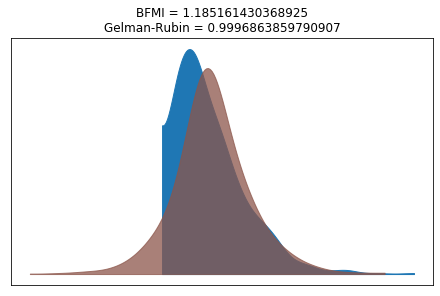

In [68]:
(pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

Our model has converged well and the Gelman-Rubin statistic looks good.

### Posterior Predictive Checks

Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Now that we have computed the posterior, we are going to illustrate how to use the simulation results to derive predictions.

The following function will randomly draw 1000 samples of parameters from the trace. Then, for each sample, it will draw 25798 random numbers from a normal distribution specified by the values of μ and σ in that sample.

In [16]:
ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model=model_g)

100%|██████████| 1000/1000 [00:01<00:00, 653.27it/s]


In [17]:
np.asarray(ppc['y']).shape

(1000, 25798)

Now, ppc contains 1000 generated data sets (containing 25798 samples each), each using a different parameter setting from the posterior.

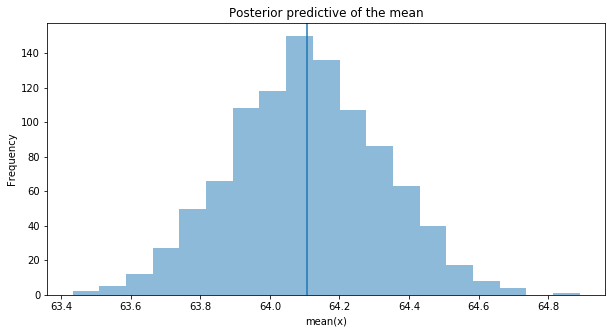

In [18]:
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(data.price.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

The inferred mean is very close to the actual ticket price mean.

### Group Comparison

We may be interested in how price compare under different fare types. we are going to focus on estimating the effect size, that is, quantifying the difference between two fare types. To compare fare types, we are going to use the mean of each fare type. Because we are Bayesian, we will work to obtain a posterior distribution of the differences of means between fare types.

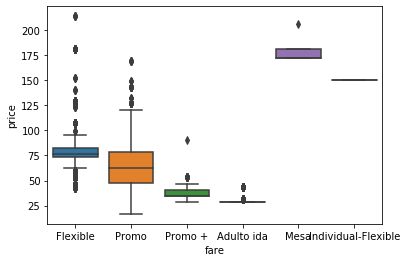

In [20]:
sns.boxplot(x='fare', y='price', data=data);

In [21]:
data.fare.unique()

array(['Flexible', 'Promo', 'Promo +', 'Adulto ida', 'Mesa',
       'Individual-Flexible'], dtype=object)

We create three variables: the price variable, representing the ticket price, the idx variable, a categorical dummy variable to encode the fare types with numbers, and finally the groups variable, with the number of fare types (6):

### Estimate model parameters per group (fare type)

In [22]:
price = data['price'].values
idx = pd.Categorical(data['fare'],
                     categories=['Flexible', 'Promo', 'Promo +', 'Adulto ida', 'Mesa', 'Individual-Flexible']).codes
groups = len(np.unique(idx))

The model for the group comparison problem is almost the same as the previous model. the only difference is that μ and σ are going to be vectors instead of scalar variables. This means that for the priors, we pass a shape argument and for the likelihood, we properly index the means and sds variables using the idx variable:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 20000/20000 [03:45<00:00, 88.84draws/s] 


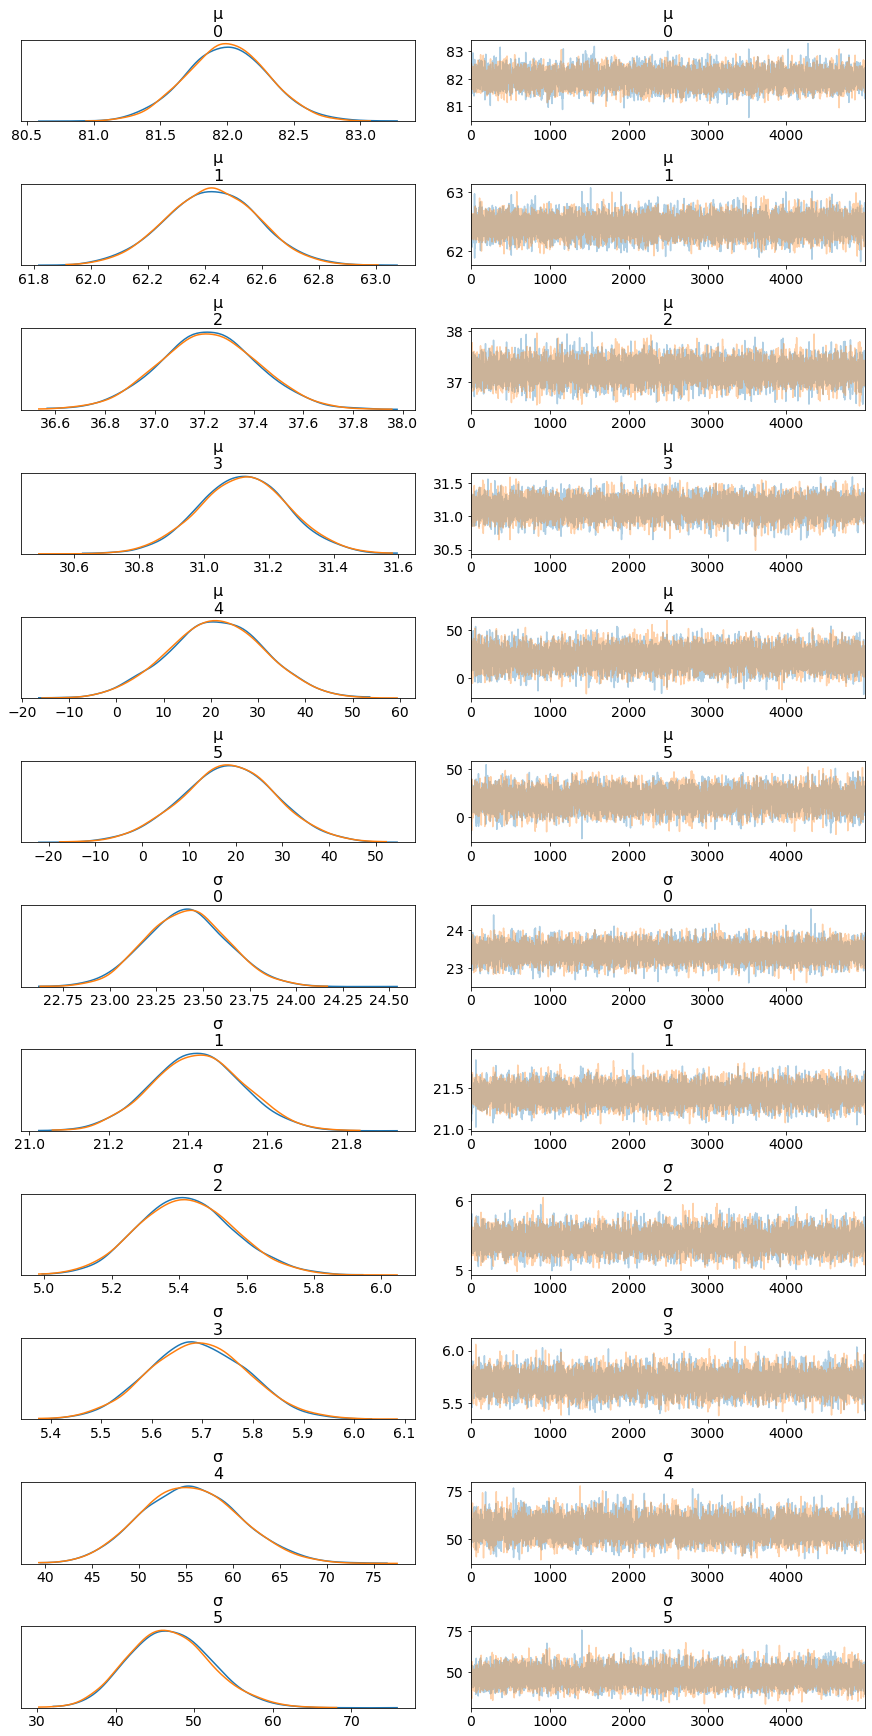

In [23]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=price)

    trace_groups = pm.sample(5000, tune=5000)
az.plot_trace(trace_groups);

This time, we get a KDE plot of μ and σ for every group (i.e. fare type).

In [24]:
flat_fares = az.from_pymc3(trace=trace_groups)
fares_gaussian = az.summary(flat_fares)
fares_gaussian

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],81.999,0.304,81.438,82.579,0.003,0.002,10596.0,10596.0,10587.0,6953.0,1.0
μ[1],62.426,0.162,62.120,62.730,0.001,0.001,11962.0,11962.0,11956.0,6943.0,1.0
μ[2],37.217,0.200,36.841,37.589,0.002,0.001,10226.0,10224.0,10242.0,7301.0,1.0
μ[3],31.123,0.137,30.870,31.390,0.001,0.001,11010.0,11009.0,11004.0,7279.0,1.0
μ[4],21.229,10.125,1.883,39.749,0.096,0.071,11065.0,10266.0,11065.0,8346.0,1.0
μ[5],18.488,10.066,-0.107,37.819,0.094,0.071,11476.0,9951.0,11464.0,8455.0,1.0
σ[0],23.411,0.217,23.014,23.824,0.002,0.001,11583.0,11581.0,11584.0,7398.0,1.0
σ[1],21.424,0.113,21.212,21.638,0.001,0.001,13693.0,13693.0,13684.0,7770.0,1.0
σ[2],5.423,0.141,5.168,5.698,0.001,0.001,13285.0,13219.0,13354.0,7238.0,1.0
σ[3],5.692,0.097,5.519,5.883,0.001,0.001,10888.0,10872.0,10903.0,7112.0,1.0


It is obvious that there are significant differnces between groups (i.e. fare types) on mean. 

To make it more visual, We plot the difference without between each fare type without repeating the comparison.

* Cohen's d is an appropriate effect size for the comparison between two means. Cohen's d introduces the variability of each group by using their standard deviations.

* probability of superiority (ps) is defined as the probability that a data point taken at random from one group has a larger value than one taken at random from another group.

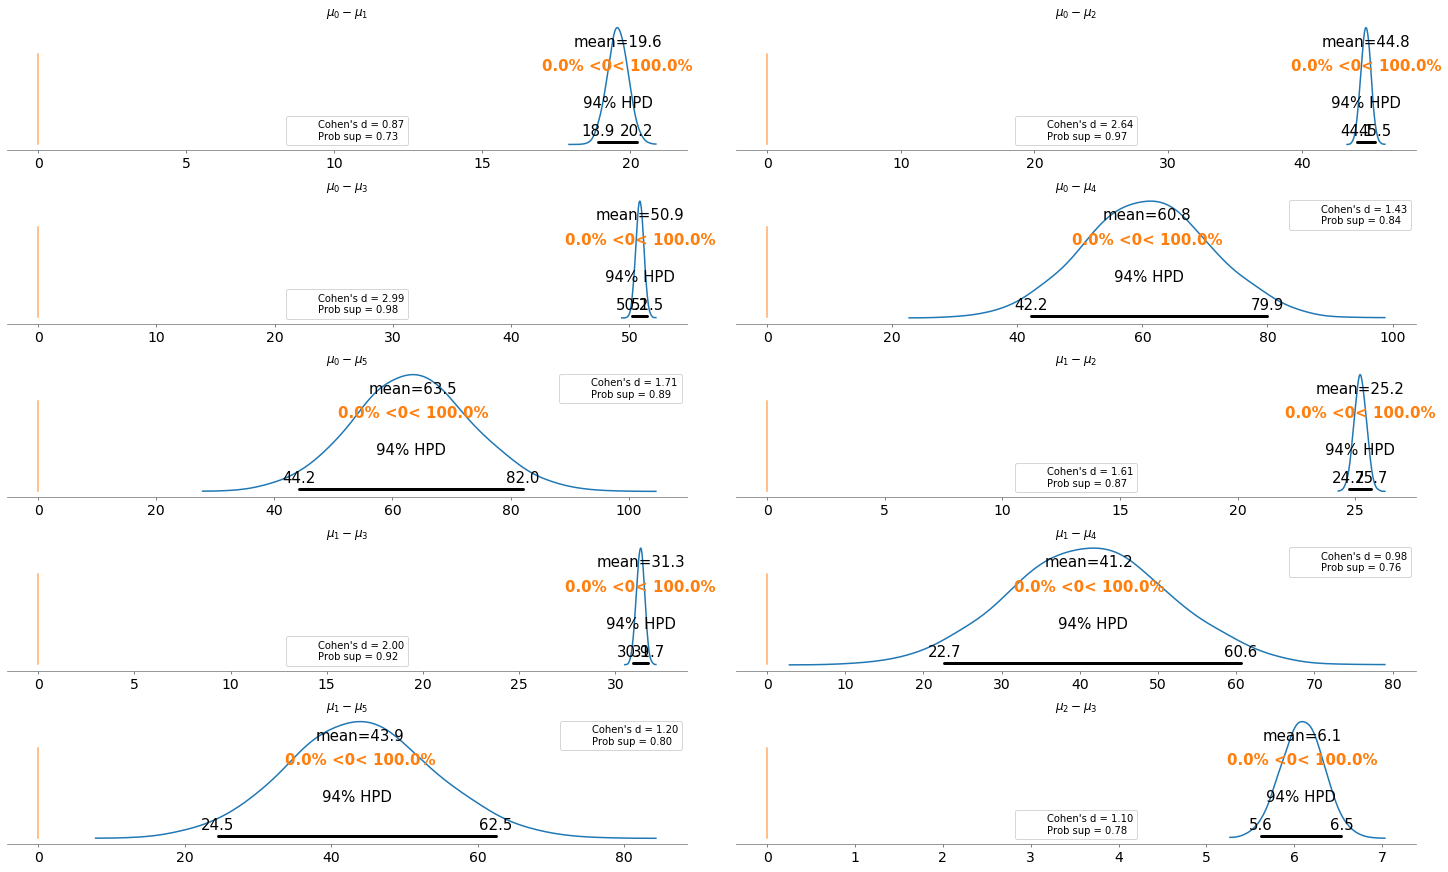

In [25]:
dist = stats.norm()

_, ax = plt.subplots(5, 2, figsize=(20, 12), constrained_layout=True)

comparisons = [(i, j) for i in range(6) for j in range(i+1, 6)]
pos = [(k, l) for k in range(5) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_groups['μ'][:, i] - trace_groups['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_groups['σ'][:, i]**2 + trace_groups['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend();

Basically, the above plot tells us that none of the above comparion cases where the 94% HPD includes the reference value of zero. This means for all the examples, we can rule out a difference of zero. The average differences range of 6.1 euro to 63.5 euro are large enough that it can justify for customers to purchase tickets according to different fare types.

### Bayesian Hierarchical Linear Regression

In [34]:
def replace_fare(fare):
    
    if fare == 'Adulto ida':
        return 1
    elif fare == 'Promo +':
        return 2
    elif fare == 'Promo':
        return 3
    elif fare == 'Flexible':
        return 4
    elif fare == 'Individual-Flexible':
        return 5
    elif fare == 'Mesa':
        return 6

data['fare_encode'] = data['fare'].apply(lambda x: replace_fare(x))

In [37]:
label_encoder = preprocessing.LabelEncoder() 
data['train_type_encode']= label_encoder.fit_transform(data['train_type'])

In [41]:
train_type_names = data.train_type.unique()
train_type_idx = data.train_type_encode.values

n_train_types = len(data.train_type.unique())

In [43]:
data[['train_type', 'price', 'fare_encode']].head()

,train_type,price,fare_encode
420104,ALVIA,82.077189,4
431888,AVE,21.950000,3
791293,AV City,38.550000,3
678876,LD-MD,34.350000,2
86381,AVE,45.300000,3


 We are interested in whether different train type affect the ticket price.

In [69]:
with pm.Model() as hierarchical_model:
    # global model parameters
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0., sd=100)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 5.)
    β_μ = pm.Normal('β_μ', mu=0., sd=100)
    β_σ = pm.HalfNormal('β_σ', 5.)

    # train type specific model parameters
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=n_train_types)  
    # Intercept for each train type, distributed around train type mean 
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=n_train_types)
    # Model error
    eps = pm.HalfCauchy('eps', 5.)

    fare_est = α_tmp[train_type_idx] + β[train_type_idx]*data.fare_encode.values

    # Data likelihood
    fare_like = pm.Normal('fare_like', mu=fare_est, sd=eps, observed=data.price)

In [70]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]
Sampling 2 chains: 100%|██████████| 8000/8000 [07:40<00:00, 17.36draws/s]


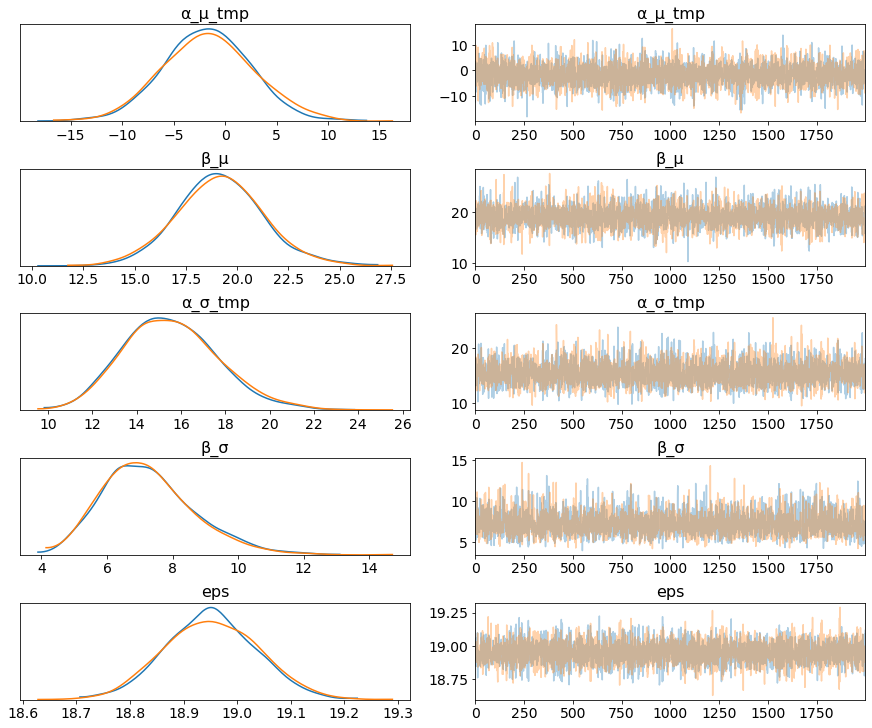

In [71]:
pm.traceplot(hierarchical_trace, var_names=['α_μ_tmp', 'β_μ', 'α_σ_tmp', 'β_σ', 'eps']);

The marginal posteriors in the left column are highly informative, "α_μ_tmp" tells us the group mean price levels, "β_μ" tells us that purchasing fare type "Promo +" increases price significantly compare to fare type "Adulto ida", and purchasing fare type "Promo" increases price significantly compare to fare type "Promo +", and so on (no mass under zero).

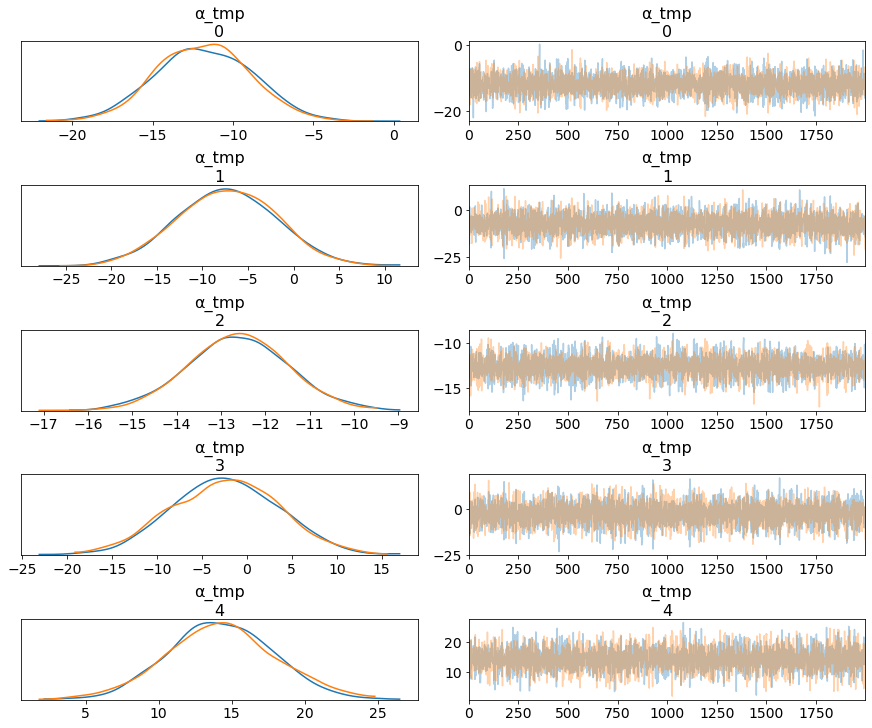

In [73]:
pm.traceplot(hierarchical_trace, var_names=['α_tmp'], coords={'α_tmp_dim_0': range(5)});

We can also see by looking at the marginals for "α_tmp" that there is quite some differences in prices between train types; the different widths are related to how much confidence we have in each paramter estimate – the more measurements per train type, the higher our confidence will be.

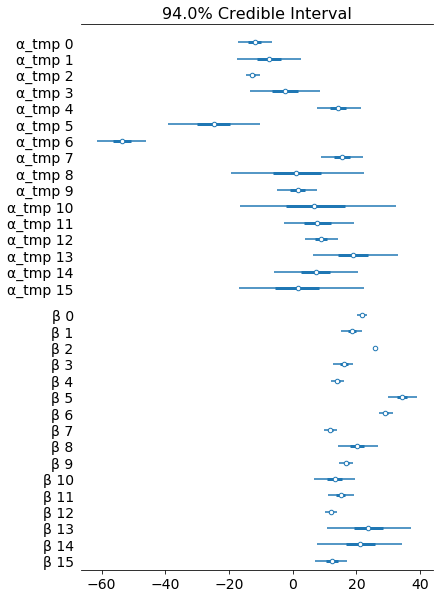

In [84]:
az.plot_forest(hierarchical_trace, var_names=['α_tmp', 'β'], combined=True);

In [85]:
ppc = pm.sample_posterior_predictive(hierarchical_trace, samples=2000, model=hierarchical_model)
az.r2_score(data.price.values, ppc['fare_like'])

100%|██████████| 2000/2000 [00:03<00:00, 516.41it/s]


r2        0.412089
r2_std    0.007676
dtype: float64

## Dataset 2 - Bank Marketing Data

#### Our Target & Goal 

* How likely am I to subscribe a term deposit?

* Experimenting of variables selection techniques.

* Explorations of the variables so serves as a good example of Exploratory Data Analysis and how that can guide the model creation and selection process.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
import theano
import theano.tensor as tt
import itertools
from IPython.core.pylabtools import figsize
pd.set_option('display.max_columns', 30)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [3]:
df = pd.read_csv('banking.csv')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


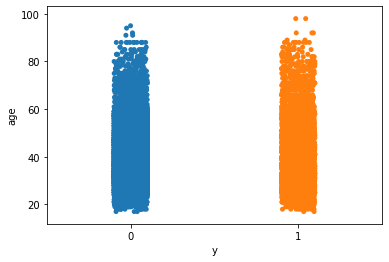

In [5]:
sns.stripplot(x="y", y="age", data=df, jitter=True)
plt.show();

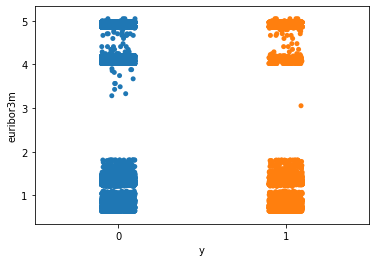

In [6]:
sns.stripplot(x="y", y="euribor3m", data=df, jitter=True)
plt.show();

In [7]:
df['education'].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [8]:
df['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [9]:
df.poutcome.unique()

array(['nonexistent', 'success', 'failure'], dtype=object)

In [7]:
def replace_education(education):
    """
    This function codes the highest education attained.
    """
    if education == 'university.degree':
        return 8
    elif education == 'professional.course':
        return 7
    elif education == 'high.school':
        return 6
    elif education == 'basic.9y':
        return 5
    elif education == 'basic.6y':
        return 4
    elif education =='basic.4y':
        return 3
    elif education == 'unknown':
        return 2
    elif education == 'illiterate':
        return 1
    
def replace_job(job):
    """
    This function codes the highest job earned.
    """
    if job == 'management':
        return 12
    elif job == 'admin.':
        return 11
    elif job == 'entrepreneur':
        return 10
    elif job == 'technician':
        return 9
    elif job == 'services':
        return 8
    elif job == 'self-employed':
        return 7
    elif job == 'blue-collar':
        return 6
    elif job == 'retired':
        return 5
    elif job == 'housemaid':
        return 4
    elif job == 'unemployed':
        return 3
    elif job == 'unknown':
        return 2
    elif job == 'student':
        return 1
    
def replace_marital(marital):
    if marital == 'married':
        return 4
    elif marital == 'single':
        return 3
    elif marital == 'divorced':
        return 2
    elif marital == 'unknown':
        return 1
    
def replace_default(default):
    if default == 'no':
        return 0
    elif default == 'yes':
        return 1
    elif default == 'unknown':
        return 2
    
def replace_housing(housing):
    if housing == 'no':
        return 0
    elif housing == 'yes':
        return 1
    elif housing == 'unknown':
        return 2

def replace_loan(loan):
    if loan == 'no':
        return 0
    elif loan == 'yes':
        return 1
    elif loan == 'unknown':
        return 2
    
def replace_contact(contact):
    if contact == 'cellular':
        return 1
    elif contact == 'telephone':
        return 2
    
def replace_poutcome(poutcome):
    if poutcome == 'failure':
        return 0
    elif poutcome == 'success':
        return 1
    elif poutcome == 'nonexistent':
        return 2

df['education'] = df['education'].apply(lambda x: replace_education(x))
df['job'] = df['job'].apply(lambda x: replace_job(x))
df['marital'] = df['marital'].apply(lambda x: replace_marital(x))
df['default'] = df['default'].apply(lambda x: replace_default(x))
df['housing'] = df['housing'].apply(lambda x: replace_housing(x))
df['loan'] = df['loan'].apply(lambda x: replace_loan(x))
df['contact'] = df['contact'].apply(lambda x: replace_contact(x))
df['poutcome'] = df['poutcome'].apply(lambda x: replace_poutcome(x))

In [8]:
look_up = {'aug': 8, 'nov': 11, 'jun': 6, 'apr': 4, 'jul': 7,
            'may': 5, 'oct': 10, 'mar': 3, 'sep': 9, 'dec': 12}

df['month'] = df['month'].apply(lambda x: look_up[x])

In [9]:
look_up = {'thu': 4, 'fri': 5, 'tue': 2, 'mon': 1, 'wed': 3}

df['day_of_week'] = df['day_of_week'].apply(lambda x: look_up[x])

In [10]:
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,6,4,3,2,1,0,1,8,4,210,1,999,0,2,1.4,93.444,-36.1,4.963,5228.1,0
1,53,9,4,2,0,0,0,1,11,5,138,1,999,0,2,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,12,3,8,0,1,0,1,6,4,339,3,6,2,1,-1.7,94.055,-39.8,0.729,4991.6,1


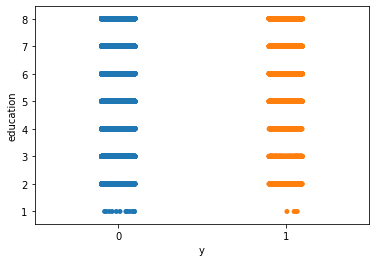

In [11]:
sns.stripplot(x="y", y="education", data=df, jitter=True)
plt.show();

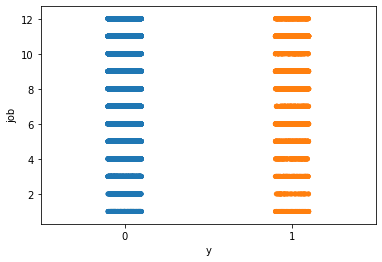

In [12]:
sns.stripplot(x="y", y="job", data=df, jitter=True)
plt.show();

In [13]:
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,6,4,3,2,1,0,1,8,4,210,1,999,0,2,1.4,93.444,-36.1,4.963,5228.1,0
1,53,9,4,2,0,0,0,1,11,5,138,1,999,0,2,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,12,3,8,0,1,0,1,6,4,339,3,6,2,1,-1.7,94.055,-39.8,0.729,4991.6,1


In [14]:
outcome = df['y']
data = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'euribor3m']]
data['outcome'] = outcome
data.corr()['outcome'].sort_values(ascending=False)

outcome        1.000000
duration       0.405274
previous       0.230181
month          0.037187
education      0.035848
age            0.030399
day_of_week    0.010051
housing        0.009552
loan          -0.005038
job           -0.023020
marital       -0.026302
campaign      -0.066357
default       -0.099324
poutcome      -0.122089
contact       -0.144773
euribor3m     -0.307771
pdays         -0.324914
Name: outcome, dtype: float64

## Logistic Regression with one independent variable

We are going to begin with the simplest possible logistic model, using just one independent variable or feature, the duration.

In [15]:
y_simple = data['outcome']
x_n = 'duration' 
x_0 = data[x_n].values
x_c = x_0 - x_0.mean()

with pm.Model() as model_simple:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    y_1 = pm.Bernoulli('y_1', p=θ, observed=y_simple)

    trace_simple = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:40<00:00, 66.44draws/s] 


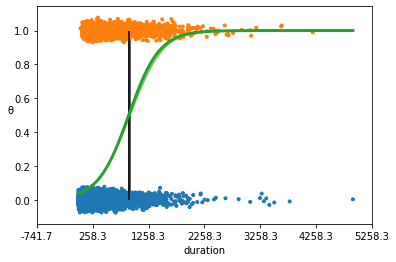

In [27]:
theta = trace_simple['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_simple['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_simple['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_simple, 0.02),
            marker='.', color=[f'C{x}' for x in y_simple])
az.plot_hpd(x_c, trace_simple['θ'], color='C2')

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1));

The above plot shows non subscription versus subscription (y = 0, y = 1). The S-shaped (green) line is the mean value of θ. This line can be interpreted as the probability of a subscription, given that we know that the last time contact duration(the value of the duration).The boundary decision is represented as a (black) vertical line. According to the boundary decision, the  values of duration to the left correspond to y = 0 (non subscription), and the values to the right to y = 1 (subscription).

In [28]:
az.summary(trace_simple, var_names=['α', 'β'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-2.349,0.019,-2.382,-2.312,0.0,0.0,1461.0,1461.0,1464.0,1317.0,1.0
β,0.004,0.000,0.004,0.004,0.0,0.0,1597.0,1596.0,1590.0,1509.0,1.0


In [29]:
ppc = pm.sample_ppc(trace_simple, model=model_simple, samples=500)
preds = np.rint(ppc['y_1'].mean(axis=0)).astype('int')

100%|██████████| 500/500 [00:02<00:00, 240.47it/s]


In [30]:
print('Accuracy of the simplest model:', accuracy_score(preds, data['outcome']))
print('f1 score of the simplest model:', f1_score(preds, data['outcome']))

Accuracy of the simplest model: 0.8933670000971157
f1 score of the simplest model: 0.2591093117408907


In [17]:
outcome.value_counts()

0    36548
1     4640
Name: y, dtype: int64

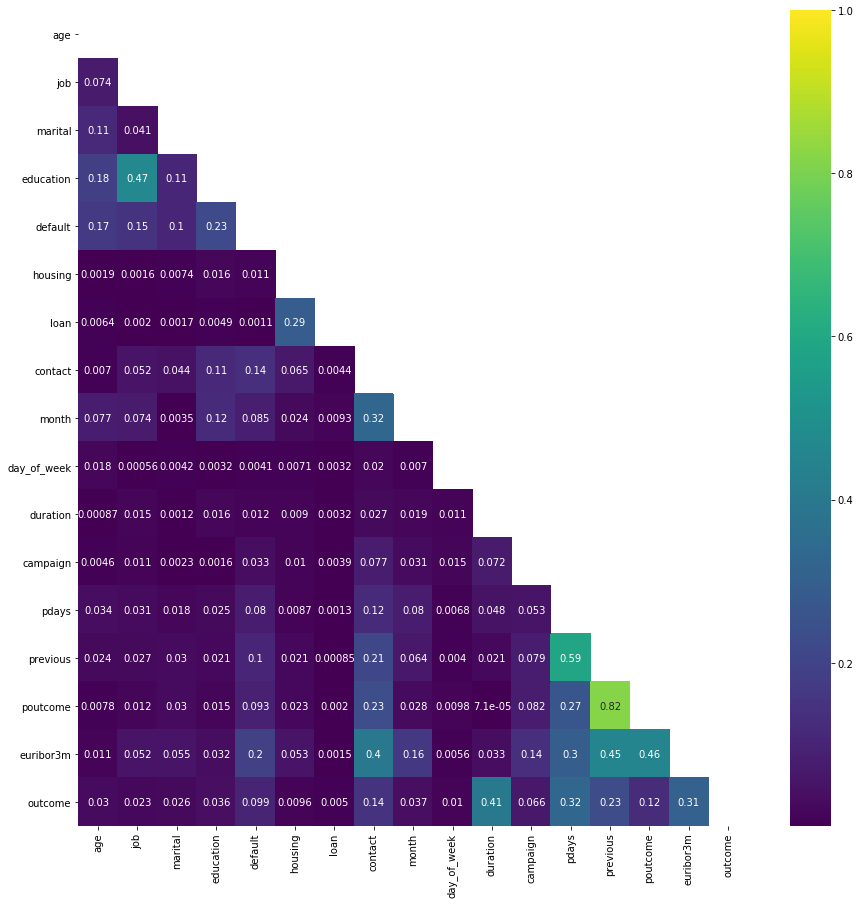

In [32]:
plt.figure(figsize=(15, 15))
corr = data.corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis');

Outcome & previous have a high correlation, we can simply remove one of them, I decide to remove poutcome.

There are not many strong correlations with the outcome variable. The highest positive correlation is 0.41.

## Logistic regression model using PyMC3 GLM method with 17 independent variables

We assume that the probability of a subscription outcome is a function of age, job, marital, education, default, housing, loan, contact, month, day of week, duration, campaign, pdays, previous and euribor3m. We need to specify a prior and a likelihood in order to draw samples from the posterior.

PyMC3 has a module - glm - for defining models. We will use PyMC3 to draw samples from the posterior. The sampling algorithm used is NUTS, in which parameteres are tuned automatically.

Then we plot the trace infromation from the first 1000 parameters.

In [18]:
# Scale age by 10, it helps with model convergence.
data['age'] = data['age'] / 10
data['age2'] = np.square(data['age'])

In [20]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('outcome ~ age + age2 + job + marital + education + default + housing + loan + contact + month + day_of_week + duration + campaign + pdays + previous + euribor3m', data, family = pm.glm.families.Binomial())
    trace = pm.sample(1000, tune = 1000, init = 'adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age2, age, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [26:25<00:00,  3.53draws/s] 
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.


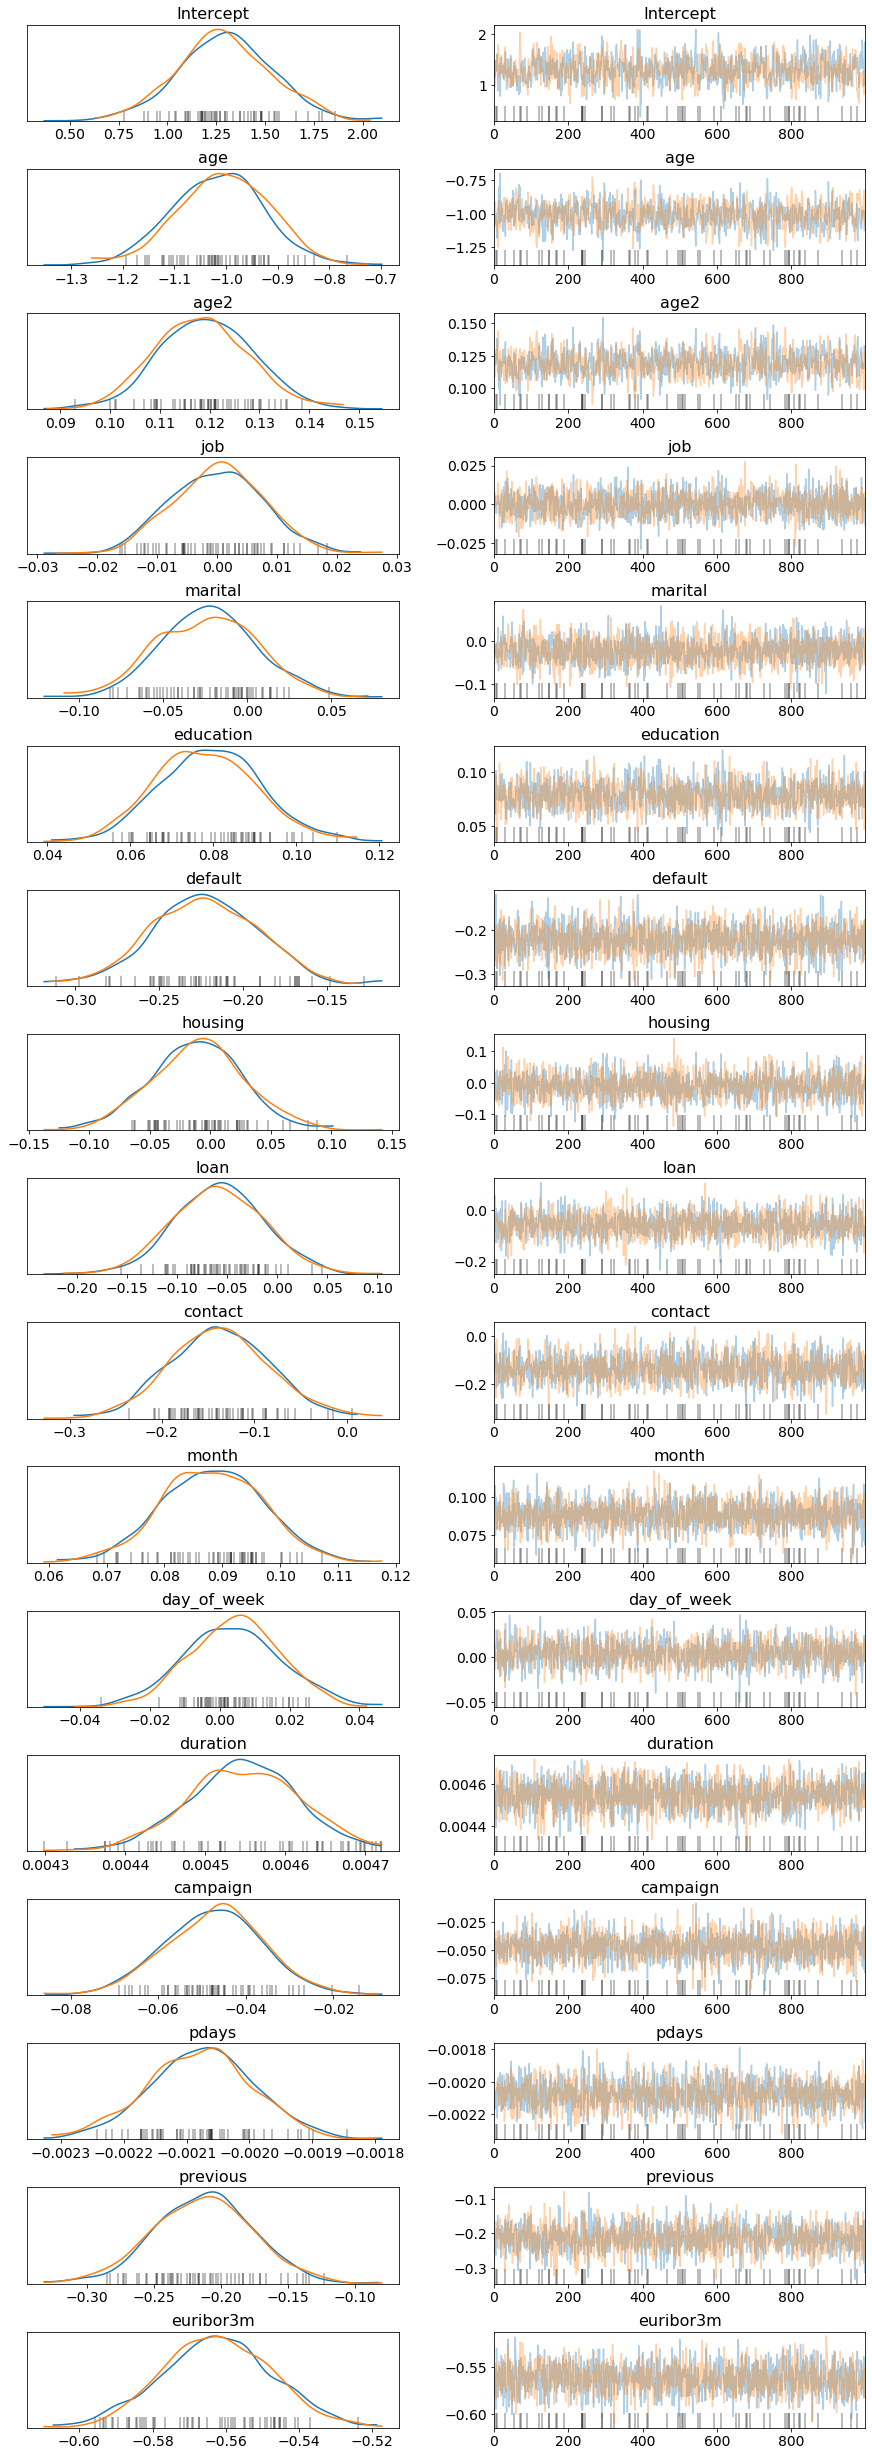

In [21]:
az.plot_trace(trace);

Each curve shows how the probability of subscribing a term deposit changes with age, given this customer is married.

The red curve represents university degree, the green curve represents and basic.9y education, the blue curve represents illiterate. For all three education levels, the probability of subscribing a term deposit decreases with age until approximately age 40, when the probability begins to increase. Notice that every curve is blurry. This is because we are actually plotting 100 different curves for each level of education. Each curve is a draw from our posterior distribution. 

In [31]:
def lm_full(trace, age, education, marital):
    shape = np.broadcast(age, education, marital).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [age/10., education, marital]])
    
    return 1 / (1 + np.exp(-(trace['Intercept'] + 
                             trace['age']*x_norm[0] + 
                             trace['age2']*(x_norm[0]**2) +
                             trace['education']*x_norm[1] +
                             trace['marital']*x_norm[2])))

lm = lambda x, samples: lm_full(samples, x, 1., 4.)
lm2 = lambda x, samples: lm_full(samples, x, 5., 4.)
lm3 = lambda x, samples: lm_full(samples, x, 8., 4.)

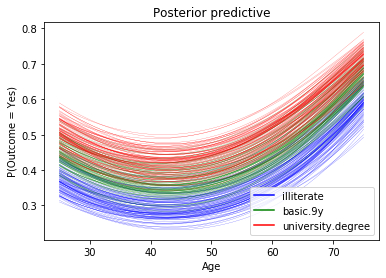

In [32]:
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm, samples=100, color='blue', alpha=.8)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm2, samples=100, color='green', alpha=.8)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm3, samples=100, color='red', alpha=.8)

blue_line = mlines.Line2D(['lm'], [], color='b', label='illiterate')
green_line = mlines.Line2D(['lm2'], [], color='g', label='basic.9y') 
red_line = mlines.Line2D(['lm3'], [], color='r', label='university.degree')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Outcome = Yes)")
plt.xlabel("Age")
plt.show();

## Estimate Odds Ratio

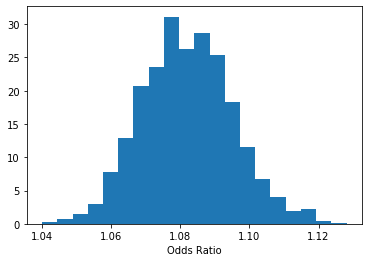

In [22]:
b = trace['education']
plt.hist(np.exp(b), bins=20, normed=True)
plt.xlabel("Odds Ratio")
plt.show();

In [23]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
print("P(%.3f < Odds Ratio < %.3f) = 0.95" % (np.exp(lb), np.exp(ub)))

P(1.058 < Odds Ratio < 1.109) = 0.95


We can interpret something along those lines: "With probability 0.95 the odds ratio is greater than 1.055 and less than 1.108, so the education effect takes place because a person with a higher education level has at least 1.055  higher probability to subscribe to a term deposit than a person with a lower education level, while holding all the other variables constant."

Compute odds ratio and percentage effect for all the variables.

In [24]:
stat_df = pm.summary(trace)
stat_df['odds_ratio'] = np.exp(stat_df['mean'])
stat_df['percentage_effect'] = 100 * (stat_df['odds_ratio'] - 1)
stat_df

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat,odds_ratio,percentage_effect
Intercept,1.294854,0.239723,0.007872,0.836391,1.777836,804.211973,1.000031,3.650462,265.046232
age,-1.010070,0.088717,0.002851,-1.178565,-0.832153,793.165859,1.003852,0.364194,-63.580635
age2,0.118898,0.009479,0.000303,0.100233,0.136978,810.530702,1.002977,1.126255,12.625465
job,0.000183,0.007517,0.000179,-0.013276,0.015327,1815.862536,1.000178,1.000183,0.018295
marital,-0.023051,0.029425,0.000586,-0.078913,0.035141,1867.474513,1.000814,0.977213,-2.278717
education,0.078765,0.012193,0.000288,0.055340,0.102337,1628.603794,1.003416,1.081950,8.194952
default,-0.222486,0.032760,0.000698,-0.289351,-0.161967,2098.688035,0.999948,0.800526,-19.947418
housing,-0.010428,0.037834,0.000899,-0.088980,0.060693,1982.930627,1.001296,0.989626,-1.037424
loan,-0.058066,0.044953,0.001070,-0.135537,0.039939,1833.596227,0.999811,0.943588,-5.641222
contact,-0.136948,0.054112,0.001223,-0.245408,-0.032852,1745.059467,0.999672,0.872016,-12.798415


with a one unit increase in education, the odds of subscribing to a term deposit increases by 8%. Similarly, for a one unit increase in euribor3m, the odds of subscribing to a term deposit decreases by 43%. holding all other independent variables constant.

## Credible Interval

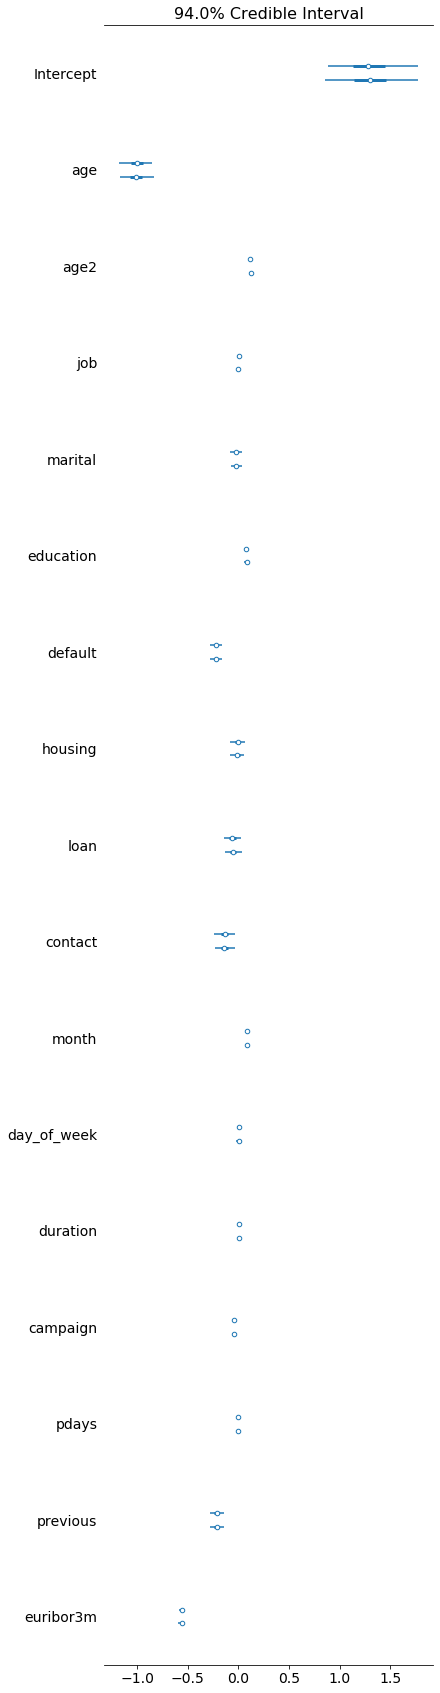

In [25]:
az.plot_forest(trace);

There's a baseline probability of subscribing a term deposit. Beyond that, age has the biggest effect on subscribing.

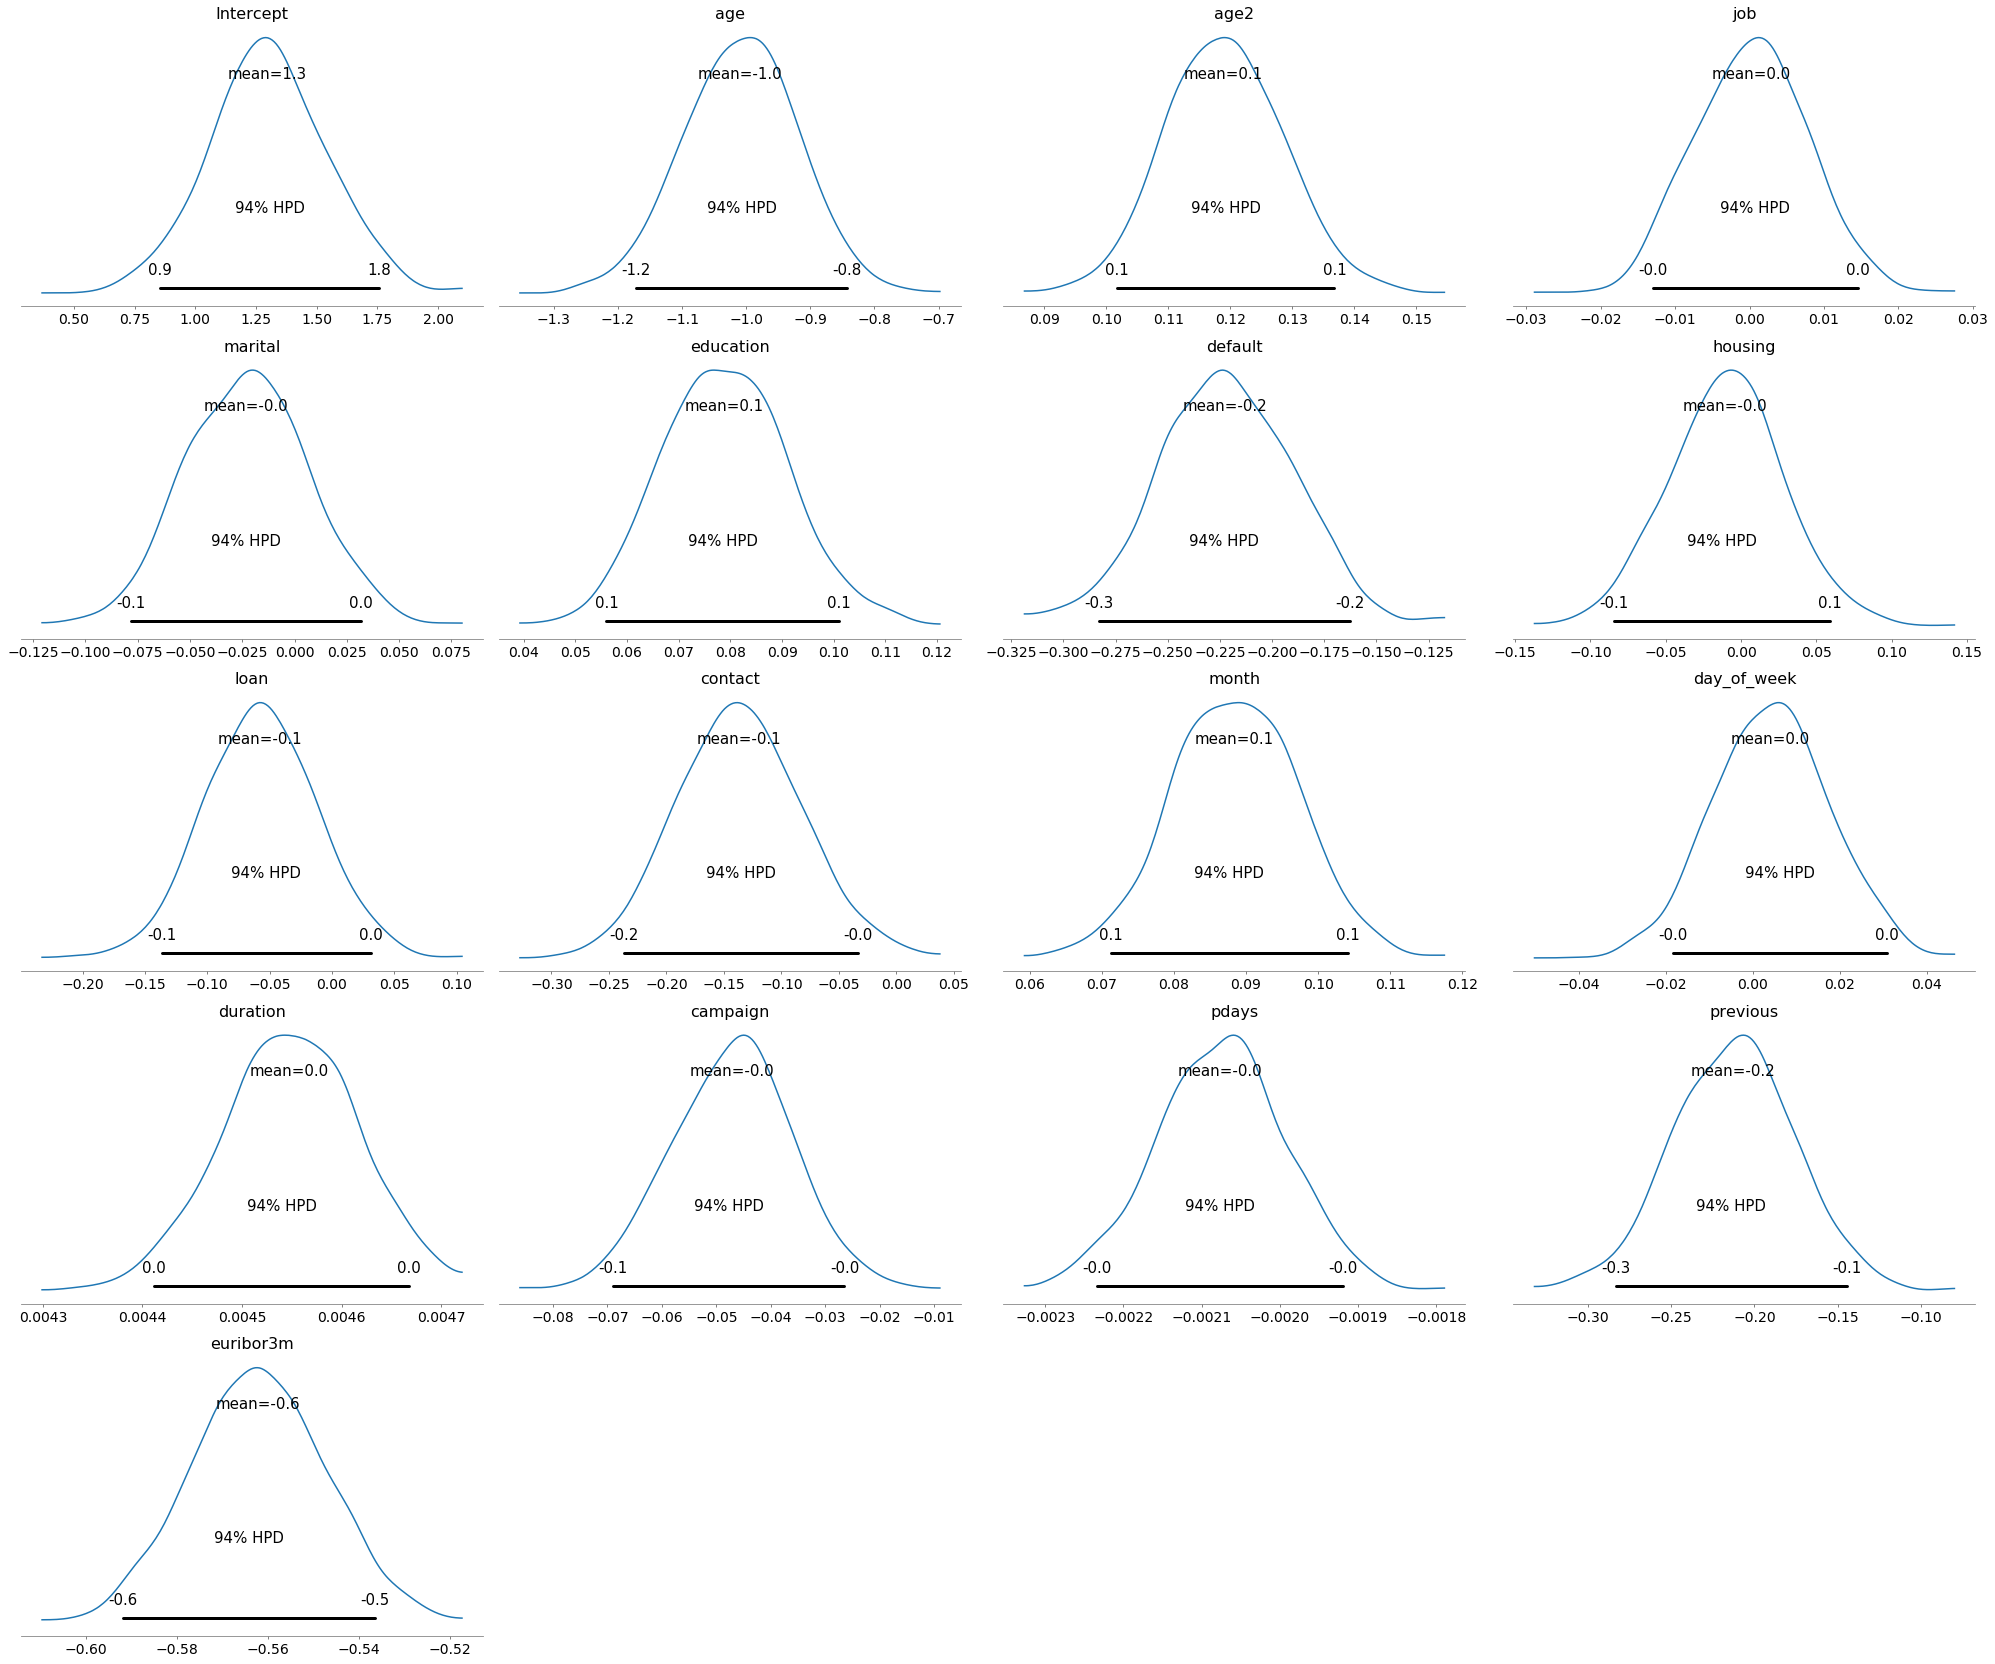

In [26]:
pm.plot_posterior(trace);

## Compare models

In [28]:
def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df,
                                    family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune=1000, init='adapt_diag')

    return models, traces

def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('outcome ~ age + job + marital + education + default + housing + loan + contact + month + day_of_week + duration + campaign + pdays + previous + euribor3m ' + ' '.join(['+ np.power(age,{})'.format(j)
                                     for j in range(2,k+1)])).strip()

models_lin, traces_lin = run_models(data, 3)


Running: k1


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [15:43<00:00,  4.93draws/s] 
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.



Running: k2


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [np.power(age, 2), euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [25:02<00:00,  3.76draws/s] 
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.



Running: k3


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [np.power(age, 3), np.power(age, 2), euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [1:32:48<00:00,  1.39s/draws]
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.


       WAIC  pWAIC   dWAIC weight      SE    dSE var_warn
k3    18273  20.28       0   0.91   227.6      0        0
k2  18302.9  19.45   29.83   0.04  227.66  12.12        0
k1  18448.7  17.87  175.66   0.05  228.27   28.4        0


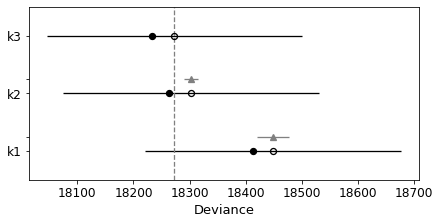

In [29]:
model_trace_dict = dict()
for nm in ['k1', 'k2', 'k3']:
    models_lin[nm].name = nm
    model_trace_dict.update({models_lin[nm]: traces_lin[nm]})

dfwaic = pm.compare(model_trace_dict, ic='WAIC')
print(dfwaic)
pm.compareplot(dfwaic);

In [30]:
dfwaic

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
k3,18273,20.28,0,0.91,227.6,0,0
k2,18302.9,19.45,29.83,0.04,227.66,12.12,0
k1,18448.7,17.87,175.66,0.05,228.27,28.4,0


## Posterior predictive check

We are going to calculate the metrics using the mean value of the parameters as a "most likely" estimate.

In [31]:
ppc = pm.sample_ppc(trace, model=logistic_model, samples=500)

100%|██████████| 500/500 [00:02<00:00, 191.77it/s]


In [32]:
ppc['y'].mean(axis=0)

array([0.006, 0.028, 0.742, ..., 0.006, 0.172, 0.02 ])

In [33]:
preds = np.rint(ppc['y'].mean(axis=0)).astype('int')

In [34]:
def plot_confusion_matrix(cm, classes = ['Not subscribe', 'Subscribe'],
                          title='Subscription Confusion matrix',
                          cmap=plt.cm.Reds):
    
    # Display the matrix in text form
    print('Confusion matrix')
    print(cm)
    figsize(8, 8)
    
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, rotation = 90, size = 12)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted Label', size = 16)

Confusion matrix
[[35648   900]
 [ 2867  1773]]


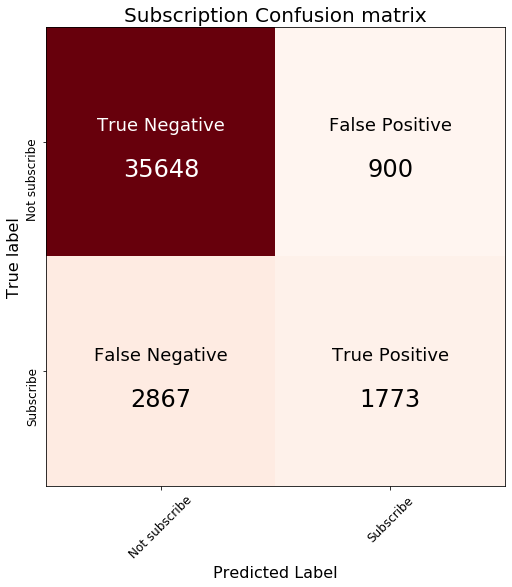

In [35]:
cm = confusion_matrix(data['outcome'], preds)
plot_confusion_matrix(cm)

In [36]:
print('Accuracy of the full model: ', accuracy_score(preds, data['outcome']))
print('f1 score of the full model: ', f1_score(preds, data['outcome']))

Accuracy of the full model:  0.908541322715354
f1 score of the full model:  0.4848899220566115
